# Evaluate and Plot Model Performance

## Imports and Setup

In [140]:
import json
import os
import sys
import random
import importlib
from collections import Counter
from types import ModuleType
from typing import List, Dict, Union

import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

# RDKit imports (suppress warnings)
from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import AllChem, Draw

# Local imports
sys.path.append("../lstm/")
sys.path.append("../vae/")
sys.path.append("../utils/")

from benchmark_vanilla_vae import VanillaVAEHarness
from model_vanilla_vae_short import VanillaMolVAE
from rnn_utils import load_model, load_rnn_model
from fast_rnn_sampler import FastSampler
from rnn_sampler import ConditionalSmilesRnnSampler
from smiles_char_dict import SmilesCharDictionary
from property_calculator import PropertyCalculator

from evaluation_utils import (
    absolute_metrics,
    amina_metrics,
    property_metrics,
    props_from_smiles,
    plot_smiles,
)

property_calculator = PropertyCalculator(["LogP"])

# Surpress RdKit warnings
logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL)

In [118]:
def smiles_to_tokens(test_smiles: List[str], max_seq_len: int) -> torch.Tensor:
    """
    Auxiliary function that tokenizes smiles using the global sd smiles character dictionary object

    Args:
        test_smiles (list[str]): List of SMILES strings to tokenize
        max_seq_len (int): The maximum sequence length for tokenization

    Returns:
        torch.Tensor: A 2D tensor containing tokenized SMILES from input padded to max_seq_len with zeros
    """

    # Instantiate a character dictionary object
    character_dictionary = SmilesCharDictionary()

    tokens = torch.zeros([len(test_smiles), max_seq_len], dtype=torch.long)

    for i, smi_str in enumerate(test_smiles):
        smi = character_dictionary.encode(smi_str)
        tokens[i][0] = character_dictionary.char_idx[character_dictionary.BEGIN]

        for j, char in enumerate(smi):
            tokens[i][j + 1] = character_dictionary.char_idx[char]

        tokens[i][len(smi) + 1] = character_dictionary.char_idx[
            character_dictionary.END
        ]

    return tokens

## Load Model to Evaluate

Load a cVAE based model who's performance to evaluate along with an appropriate sampler object. 
Explicit and One-Shot models must be loaded using seperate code, and stored in the `vae_model` and `vae_sampler` sampler. 

Each model trained by the code in this project is stored as two files:
- A `.pt` file containing the model weights assigned to the `model_weights` variable
- A `.json` file containing the model parameters assigned to the `model_definit` variable

### Load Regular (One-Shot) cVAE Models

In [119]:
# NOTE: Replace with desired model class
model_definit = "../models/QM9/vae/cVAE/cVAE_odd-wind-32_Epoch_310_Vl_0.114.json"
model_weights = "../models/QM9/vae/cVAE/cVAE_odd-wind-32_Epoch_310_Vl_0.114.pt"

# Load model and instantiate sampler class
cvae_sampler = VanillaVAEHarness(batch_size=64, device="cpu")
cvae_model = load_model(
    model_class=VanillaMolVAE,
    model_definition=model_definit,
    model_weights=model_weights,
    device="cpu",
)

# Ensure model is on correct device
device = "cpu"

cvae_model = cvae_model.to(device)
cvae_model.device = device
cvae_model.encoder.device = device
cvae_model.state_decoder.device = device

a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited


/home/chrome/Code/De-Novo-Drug/De-novo-drug-design/evaluation/../lstm/rnn_utils.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_w

### Load Explicit (w/ or wo/ Teacher Forcing) VAE Model

In [ ]:
# NOTE: Replace with desired model class
model_definit = "../models/QM9/explicit_vae_tf/EXP-cVAE-KLD-TF/SD_REG_VANILLA_VAE_throbbing-heart-74_Epoch_236_Vl_0.130.json"
model_weights = "../models/QM9/explicit_vae_tf/EXP-cVAE-KLD-TF/SD_REG_VANILLA_VAE_throbbing-heart-74_Epoch_236_Vl_0.130.pt"

# Load the explicit versions of the sampler and model classes
file_path = "../explicit_vae/model_vanilla_vae.py"
spec = importlib.util.spec_from_file_location("model_vanilla_vae.py", file_path)
module = importlib.util.module_from_spec(spec)
sys.modules["model_vanilla_vae"] = module
spec.loader.exec_module(module)

explicit_model_class = module.VanillaMolVAE
file_path = "../explicit_vae/action_sampling_vae_sampler.py"

spec = importlib.util.spec_from_file_location(
    "action_sampling_vae_sampler.py", file_path
)
module = importlib.util.module_from_spec(spec)
sys.modules["action_sampling_vae_sampler"] = module
spec.loader.exec_module(module)

harness_class = module.VanillaVAEHarness

# Load model and instantiate sampler class
exp_cvae_sampler = harness_class(batch_size=64, device="cpu")
exp_cvae_model = load_model(
    model_class=explicit_model_class,
    model_definition=model_definit,
    model_weights=model_weights,
    device="cpu",
)

a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited


## Load Dataset and Compute Dataset Summary Statistics

### Select Model To Evaluate

In [121]:
# NOTE: Set to either cvae_model or exp_cvae_model
vae_model = exp_cvae_model

# NOTE: Set to either cvae_sampler or exp_cvae_sampler
vae_sampler = exp_cvae_sampler

Load smiles and corresponding properties for train, test and validation splits. 

- The code assumes that the QM9 and ZINC250k datasets have been downloaded and preprocessed according to the directory instructions and are saved
in the `data/qm9_36` and `data/zinc250k_120` folders respectively.
- The code uses the LogP property and assumes it has been computed for each dataset SMILES 

In [122]:
# NOTE: Set to wither 'QM9' or 'ZINC'
dataset_choice = "QM9"

In [123]:
ZINC_DATASET_PATH = "../data/zinc250k_120/"
QM9_DATASET_PATH = "../data/qm9_36/"

# Load appropriate dataset
if dataset_choice.upper() == "ZINC":
    data_file = os.path.join(ZINC_DATASET_PATH, "ZINC_clean.csv")
    dataset_df = pd.read_csv(data_file)
    print("Columns:", dataset_df.columns)

    props = list(dataset_df.drop(["ZINC_ID", "SMILES"], axis=1).columns)
    print(f"Properties in dataset: {props}")

    # Load data splits
    indices = np.load(os.path.join(ZINC_DATASET_PATH, "data_splits.npy"))

    # Split SMILES
    train_smiles = dataset_df["SMILES"].values[indices == 0]
    val_smiles = dataset_df["SMILES"].values[indices == 1]
    test_smiles = dataset_df["SMILES"].values[indices == 2]

    # Split properties
    train_props = dataset_df["LogP"].values[indices == 0].astype(float)
    val_props = dataset_df["LogP"].values[indices == 1].astype(float)
    test_props = dataset_df["LogP"].values[indices == 2].astype(float)

elif dataset_choice.upper() == "QM9":
    data_file = os.path.join(QM9_DATASET_PATH, "QM9_clean.csv")
    dataset_df = pd.read_csv(data_file)

    props = list(dataset_df.drop(["QM9_id", "SMILES"], axis=1).columns)

    # Load data splits
    indices = np.load(os.path.join(QM9_DATASET_PATH, "data_splits.npy"))

    # Split SMILES
    train_smiles = dataset_df["SMILES"].values[indices == 0]
    val_smiles = dataset_df["SMILES"].values[indices == 1]
    test_smiles = dataset_df["SMILES"].values[indices == 2]

    # Split properties
    train_props = dataset_df["LogP"].values[indices == 0].astype(float)
    val_props = dataset_df["LogP"].values[indices == 1].astype(float)
    test_props = dataset_df["LogP"].values[indices == 2].astype(float)

else:
    raise ValueError(f"Unsupported dataset choice: {dataset_choice}")

Estimate the mean property difference (error) between a random pair of dataset molecules. 
This can serve as a lower bound for the property error; a model that ignores conditioning information 
and samples random SMILES from the fit data distribution.

In [127]:
def estimate_mean_error_random_pairs(
    properties: Union[List[float], np.ndarray], num_pairs: int = 100000
) -> float:
    """
    Utility function that estimates mean difference between from random pairs dataset molecules.

    Args:
        properties (List | numpy.ndarray): List of dataset property scores
        num_pairs (Int): Sample size for estimate; number of random pairs to consider

    Returns:
        (float): Mean error between the random pairs.
    """
    errors = []
    n = len(properties)

    for _ in tqdm(range(num_pairs)):
        # Select two random smiles
        i, j = random.sample(range(n), 2)

        # Compute the error (absolute difference)
        error = abs(properties[i] - properties[j])
        errors.append(error)

    # Return mean error
    mean_error = np.mean(errors)
    return mean_error


mean_train_error_estimate = estimate_mean_error_random_pairs(train_props)
print(f"Estimated mean LogP difference for train smiles: {mean_train_error_estimate}")

100%|██████████| 100000/100000 [00:00<00:00, 283568.87it/s]

Estimated mean LogP difference for train smiles: 1.1171213416


Plot the distributions of SMILES string lengths and LogP values in the entire dataset.

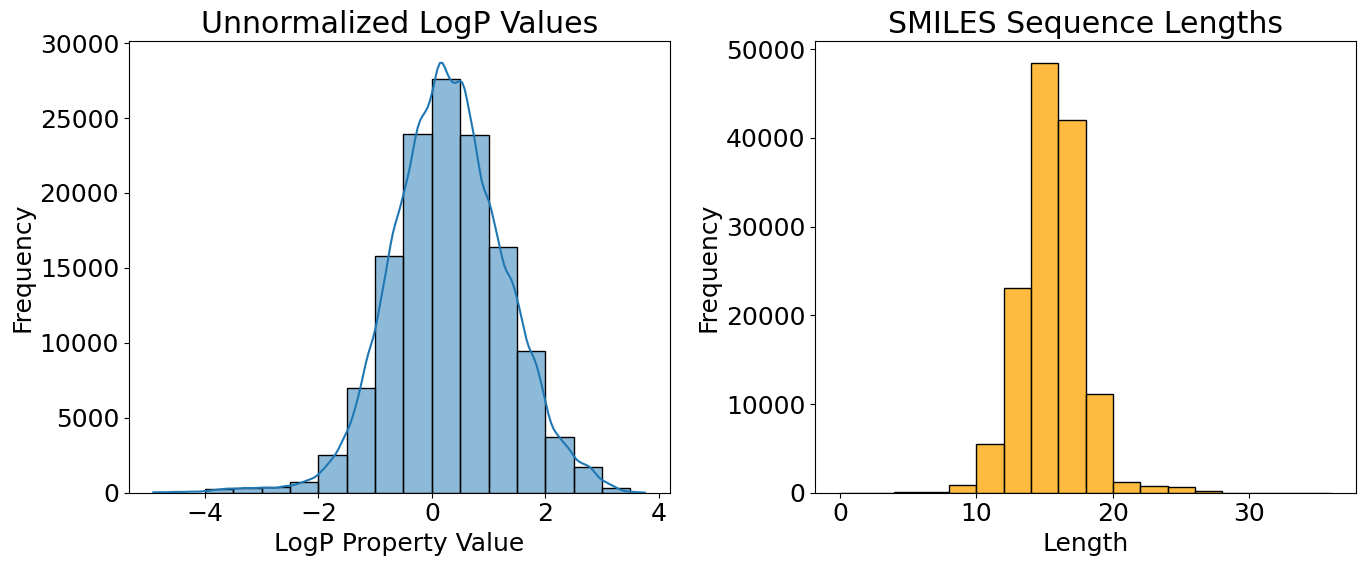

In [ ]:
plt.rcParams.update({"font.size": 18})

if dataset_choice == "ZINC":
    prop_bins = np.arange(-8, 8, 0.5)
    len_bins = np.arange(0, 130, 5)
elif dataset_choice == "QM9":
    prop_bins = np.arange(-4, 4, 0.5)
    len_bins = np.arange(0, 38, 2)

all_logp = list(train_props) + list(test_props) + list(val_props)
all_lens = [len(a) for a in (list(test_smiles) + list(train_smiles) + list(val_smiles))]

# Create left subplot for LogP dist. and right for SMILES seq. length
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Generate and display plots
sns.histplot(all_logp, bins=prop_bins, kde=True, ax=ax[0])
ax[0].set_title("Unnormalized LogP Values")
ax[0].set_xlabel("LogP Property Value")
ax[0].set_ylabel("Frequency")

sns.histplot(all_lens, bins=len_bins, kde=False, color="orange", ax=ax[1])
ax[1].set_title("SMILES Sequence Lengths")
ax[1].set_xlabel("Length")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Print (latex formatted) table of SMILES characters and for each, their counts and normalized frequencies in the dataset.

In [52]:
# Compute character counts and normalized frequencies
char_counter = Counter(
    "".join(list(test_smiles) + list(val_smiles) + list(train_smiles))
)
total_chars = sum(char_counter.values())
normalized_char_counter = {
    char: freq / total_chars for char, freq in char_counter.items()
}

# Generate code for LaTeX table with characters listed vertically and frequencies in rows
latex_table = "\\begin{table}[ht]\n\\centering\n\\begin{tabular}{|c|c|c|}\n\\hline\n"
latex_table += "Character & Frequency & Normalized Frequency \\\\\n\\hline\n"
for char, freq in char_counter.items():
    latex_table += (
        f"{char} & {freq} & {normalized_char_counter[char]:.2f} \\\\\n\\hline\n"
    )
latex_table += "\\end{tabular}\n\\caption{Character Frequencies and Normalized Frequencies}\n\\end{table}"

print(latex_table)

\begin{table}[ht]
\centering
\begin{tabular}{|c|c|c|}
\hline
Character & Frequency & Normalized Frequency \\
\hline
C & 767830 & 0.38 \\
\hline
O & 177823 & 0.09 \\
\hline
( & 118216 & 0.06 \\
\hline
) & 118216 & 0.06 \\
\hline
# & 37027 & 0.02 \\
\hline
N & 98355 & 0.05 \\
\hline
= & 94597 & 0.05 \\
\hline
1 & 259368 & 0.13 \\
\hline
[ & 12523 & 0.01 \\
\hline
H & 10568 & 0.01 \\
\hline
3 & 35634 & 0.02 \\
\hline
+ & 1847 & 0.00 \\
\hline
] & 12523 & 0.01 \\
\hline
- & 1974 & 0.00 \\
\hline
2 & 131751 & 0.07 \\
\hline
c & 78726 & 0.04 \\
\hline
n & 41409 & 0.02 \\
\hline
o & 10174 & 0.01 \\
\hline
F & 3314 & 0.00 \\
\hline
4 & 4952 & 0.00 \\
\hline
5 & 174 & 0.00 \\
\hline
\end{tabular}
\caption{Character Frequencies and Normalized Frequencies}
\end{table}


## Compute Performance Metrics for Selected Model

Examine how well the latent space learned by the Encoder approximates the desired standard normal distribution N(0, 1). In practice, model's trained to convergence tend to encode latent points too close to the origin (posterior collapse), and better performance can be obtained by sampling from the approximated aggregate poterior distribution of the Encoder as opposed to N(0, 1).

### Evaluate Learned Latent Distribution

In [53]:
# NOTE: Select sample size
sample_size = 5000

# Randomly select SMILES from the test set
indices = random.sample(range(len(test_smiles)), sample_size)
smiles_subset = [test_smiles[i] for i in indices]

# Convert SMILES to tokens
tokens_subset = smiles_to_tokens(smiles_subset, vae_model.max_decode_steps)

# Pass tokens through the encoder
z_mean, logvar = vae_model.encoder(tokens_subset)

# Calculate mean and std of the encoder outputs
z_mean_mean = z_mean.mean(axis=0).mean()
z_mean_std = z_mean.std(axis=0).mean()

print("===== Encoder Statistics =====")
print("Ideally, mean(z_mean) = 0.")
print("Ideally, mean(logvar) = 0, because for N(0, 1): σ²=1 => log(σ²)=0.")
print(f"Mean of z_mean (over latent dimensions): {z_mean_mean:.4f}")
print(f"Average std of z_mean (over latent dimensions): {z_mean_std:.4f}")

# Temporarily turn off reparameterization, then sample latent points
old_reparam_setting = vae_model.reparam
vae_model.reparam = False
latents = vae_model.reparameterize(z_mean, logvar)
vae_model.reparam = old_reparam_setting

# Evaluate distribution of sampled latents
latents_np = latents.detach().numpy()
latents_std = np.std(latents_np, axis=0).mean()
latents_var = np.var(latents_np, axis=0).mean()

print("\n===== Reparameterized Latent Distribution =====")
print(f"Mean std across latent dimensions (Ideally = 1): {latents_std:.4f}")
print(f"Mean variance across latent dimensions (Ideally = 1): {latents_var:.4f}")

# NOTE: Some prior works sample latent points for the decoder from the approximated aggregate posterior
# of the encoder instead of from N(0, 1). In that case, set `vae_sampler.sampling_std_div` to the
# estimated standard deviation instead of 1.0.

vae_sampler.sampling_std_div = 1.0

# To sample from approx. agg. posterior instead, set:
# vae_sampler.sampling_std_div = float(z_mean_std)

===== Encoder Statistics =====
Ideally, mean(z_mean) = 0.
Ideally, mean(logvar) = 0, because for N(0, 1): σ²=1 => log(σ²)=0.
Mean of z_mean (over latent dimensions): -0.0001
Average std of z_mean (over latent dimensions): 0.0343

===== Reparameterized Latent Distribution =====
Mean std across latent dimensions (Ideally = 1): 0.0343
Mean variance across latent dimensions (Ideally = 1): 0.0013


Generate some random SMILES sampled from random latent points and random test-set properties. 

In [ ]:
props = random.sample(list(test_props), 10)
inp_props = torch.tensor([[a] for a in props]).clone()
smp = vae_sampler.sample(vae_model, inp_props)

print("Example SMILES sampled from model:")
for i in range(len(smp)):
    print(f"SMILES {i}: " + smp[i])

/home/chrome/Code/De-Novo-Drug/De-novo-drug-design/evaluation/../explicit_vae/action_sampling_vae_sampler.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  properties = torch.tensor(properties).clone()
/home/chrome/Code/De-Novo-Drug/De-novo-drug-design/evaluation/../explicit_vae/model_vanilla_vae.py:306: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()


Example SMILES sampled from model:
SMILES 0: Nc1ncoc(=N)oc1
SMILES 1: O=CCNC1=NC(C)CC1
SMILES 2: N#CC1C2C(CN1)C2CO
SMILES 3: C12CC3C4(C3)C1N2C=O
SMILES 4: CN1CCC#CC(=O)C1
SMILES 5: CCC12C(C2)CC1OC
SMILES 6: N#CC(C)(C)OC1CC1
SMILES 7: OCC1CCCCC=C1
SMILES 8: CC1(N=C)(C=O)C(C)O1
SMILES 9: Cc1cnc(FC(C)F)1


### Compute Generative/Prior Performance Metrics for Model

Evaluate the ability of the decoder model to generate new molecules from latent point - target property pairs. SMILES are considered to be valid if they can be sucesfully decoded by RdKit, and novel if they are not present in the training set.

We evaluate the model's performance by using a standard set of generative performance metrics defined as in the GuacaMol benchmark. They are computed are as follows:

- Validity: %Valid = #Valid / #Generations
- Uniqueness: %Unique = #Unique Valid / #Valid
- Novelty: %Novel = #Valid - #Valid_in_train_set / #Valid
- Property Error: MSE = Mse (target_property - achieved_property)^2

Where novelty and uniqueness consider the canonical SMILES version of a generated molecule determined by RdKit (same as in the dataset)


In [145]:
def compute_prior_metrics_conditional_model(
    model: torch.nn.Module,
    sampler,
    train_set: List[str],
    test_props: Union[List[float], np.ndarray],
    property_calculator: PropertyCalculator,
    num_sample: int = 1000,
    num_decode: int = 100,
    return_valid: bool = False,
) -> Dict[str, float]:
    """
    Computes performance metrics for a sample of molecules generated by the decoder from latent
    points sampled z ∼ N (O, I) and a set of provided target properties.

    Args:
        model (nn.Module): Standard cVAE model object
        sampler (Sampler): Sampler object implementing standard .sample method
        train_set (list[str]): Set of model training smiles for novelty calculation
        test_props (list[float]): List of properties uniformly sampled from molecules in test set, at least num_sample in length
        property_calculator (Property Calculator): Property calculator utility object
        num_sample (int) : Number of latent points to sample
        num_decode (int): Number of times to decode each latent point - property pair
        return_valid (float): If True, return list of valid molecules instead of performance metrics

    Returns:
        dict:
            {
                "validity": float,
                "uniqueness": float,
                "novelty": float,
                "MAE": float
            }
        or
        list[str]: If return_valid is True, returns a list of all valid SMILES.d

    TODO: Currently sample is called for each property. This could be sped up significantly with vectorisation.
    """

    # Assert we have enough properties for the desired sample size
    assert num_sample < len(test_props)

    # Copy properties and train smiles to prevent sampler side effects
    train_set = set(train_set.copy())
    test_props = test_props.copy()

    # Uniformly sample subset of properties for each latent point
    props = random.sample(list(test_props), num_sample)

    # Initialize counter variables
    n_all_smiles = 0
    n_valid_smiles = 0
    n_valid_in_train = 0
    valid = []
    total_me = 0

    # For each target property
    for prop in tqdm(props):
        # Decode for each of num_decode samples
        repeated_prop = torch.tensor([[prop]] * num_decode)
        prop_smiles = sampler.sample(model, repeated_prop.clone())

        for smi in prop_smiles:
            # Count and parse each decoded SMILES
            n_all_smiles += 1
            mol = Chem.MolFromSmiles(smi)

            # If SMILES was sucesfully parsed (VALID) and contained an END token
            if mol is not None and len(smi) < (model.max_decode_steps - 1):
                # Canonicalize the SMILES for checking novelty and uniqueness
                can_smi = Chem.MolToSmiles(mol, canonical=True)
                n_valid_smiles += 1
                valid.append(can_smi)

                # Compute mean error between target and obtained properties using pc (property calculator)
                total_me += abs(
                    property_calculator(mol)[0] - prop
                )  # We choose to compute MAE instead of MSE because it is less sensitive to outliers

                # Check if SMILES in train_set
                if can_smi in train_set:
                    n_valid_in_train += 1

    # If return_valid is True, return the list of valid decoded SMILES
    if return_valid:
        return valid

    # Avoid raising ZeroDivisionError in case no valid SMILES are generated
    if n_valid_smiles == 0:
        return {
            "Validity": 0.0,
            "Uniqueness": 0.0,
            "Novelty": 0.0,
            "MAE": float("nan"),  # or 0.0
        }

    # If return_valid is False, compute and return a tuple containing the performance metrics
    unique_valid = set(valid)
    validity = n_valid_smiles / n_all_smiles
    uniqueness = len(unique_valid) / n_valid_smiles
    novelty = (n_valid_smiles - n_valid_in_train) / n_valid_smiles
    me = total_me / n_valid_smiles

    # assert n_all_smiles == num_sample * num_decode

    return {
        "Validity": validity,
        "Uniqueness": uniqueness,
        "Novelty": novelty,
        "Property MAE": me,
    }

Estimate and print the generative performance metrics for the selected model.

In [59]:
# Set sample size parameters
lantent_sample_size = 50
num_decodes_per_latent = 1


results = compute_prior_metrics_conditional_model(
    vae_model,
    vae_sampler,
    train_smiles,
    property_calculator=property_calculator,
    test_props=test_props,
    num_sample=lantent_sample_size,
    num_decode=num_decodes_per_latent,
    return_valid=False,
)

print("\n\n===== Metrics =====")
for metric_name, metric_value in results.items():
    if isinstance(metric_value, float):
        print(f"{metric_name.capitalize()}: {metric_value:.4f}")
    else:
        print(f"{metric_name.capitalize()}: {metric_value}")

100%|██████████| 50/50 [00:11<00:00,  4.52it/s]



===== Metrics =====
Validity: 0.7200
Uniqueness: 1.0000
Novelty: 0.6111
Mae: 0.3722


### Estimate Reconstruction Performance for Model

Estimate the reconstruction performance for the model. Reconstruction performance is analogous to the reconstruction objective used when training VAE's. 


It can be estimated as follows:

*For a given set of input molecules x, encode each of their SMILES n times to obtain latent points z. Then decode these with the respective properties of x a further m times to obtain a set of reconstructed molecules x'. The reconstruction error estimate is then the proportion of x' SMILES that represent the same molecule as their corresponding moleule from x.*




In [60]:
def compute_reconstruction_vae_model(
    test_smiles: List[str],
    test_props: Union[List[float], torch.Tensor],
    vae_model: torch.nn.Module,
    vae_sampler,
    n_encodes: int = 10,
    n_decodes: int = 25,
) -> float:
    """
    test_smiles is array-like of test smiles for reconstruction
    test_props is

    n_encodes is number of encodings per test_set instance
    n_decodes is number of decodings per latent encoding

    Do one at a time since we're deconding 250x more points


    From andSD-VAE paper:
    for each of the structured data in the held-out dataset, we encode it 10 times and decoded (for each encoded latent space representation) 25 times, and report the portion of decoded structures that are the same as the input ones

    Args:
        test_smiles (list[str]):
        test_props (list[float]):
        vae_model (nn.Module): Standard cVAE model.
        vae_sampler (Sampler): Standard Sampler object implementing the .sample method.
        n_encodes (int): The number n of times to encode each input SMILES.
        n_decodes (int): The number m of times to decode each latent-property pair.

    Returns:
        (float): Proportion of sucesfully reconstructed instances in the sample; an estimate
        of the models' reconstruction performance
    """

    # Initialize counter variables for number of sucesfully reconstructed SMILEs and total number of SMILES in the sample
    n_same = 0
    n_total = 0

    # Copy to avoid sampler side effects
    test_props = test_props.copy()

    # Reformat properties
    edited_props = torch.tensor([[a] for a in test_props])

    # Ensure model is in Eval mode and inputs are probabilistically encoded (.reparam = True)
    vae_model.eval()

    # NOTE: An alternate but still valid definition of reconstruction can consider reconstructions from the mean encoding of each input SMILES
    # to compute this set the .reparam parameter should be set to False
    vae_model.reparam = True

    for smindex in tqdm(range(len(test_smiles))):
        # and max_seq_len = model.max_decode_steps
        # enc_b_size = n_encodes
        smile = test_smiles[smindex : smindex + 1]
        prop = edited_props[smindex : smindex + 1]

        # Convert smiles to tokens
        tokens = smiles_to_tokens(smile, vae_model.max_decode_steps)

        input_tokens = tokens.repeat(n_encodes, 1)
        input_properties = prop.repeat(n_encodes, 1)

        # Run through the model
        latent_points, log_var = vae_model.encoder(input_tokens)
        samp_latents = vae_model.reparameterize(
            mu=latent_points, logvar=log_var
        )  # torch.tensor(vae_model.eps_std))

        # Repeat latents n_decode times
        # Repeat properties n_decode times
        samp_latents = samp_latents.repeat(n_decodes, 1)
        repeated_props = input_properties.repeat(n_decodes, 1)

        sampled_smiles = vae_sampler.sample(
            model=vae_model,
            properties=repeated_props.clone(),
            random=True,
            latent_points=samp_latents,
        )

        # Samp latents now contains n_encodings encoded (random latent points)
        # TODO: Do I reparam here? It's the only source of randomness for encodings but not how inference with a vae is typically done
        # feels right for judging the reconstruction loss though

        assert len(sampled_smiles) == n_encodes * n_decodes

        # Now decode probabilitically n_decode times
        counts = Counter(sampled_smiles)

        n_same += counts[smile[0]]

        n_total += len(sampled_smiles)

    return n_same / n_total

Estimate reconstruction performance for a sample of input molecules.

In [61]:
# Sample parameters
sample_size = 50
n_num_encodes = 5
m_num_decodes = 5

# Create input sample and compute reconstruction
indices = random.sample(range(len(test_smiles)), sample_size)
smiles_1k = [test_smiles[i] for i in indices]
properties_1k = [test_props[i] for i in indices]

result = compute_reconstruction_vae_model(
    smiles_1k,
    properties_1k,
    vae_model,
    vae_sampler,
    n_encodes=n_num_encodes,
    n_decodes=m_num_decodes,
)

print("\n\n===== Reconstruction Performance =====")
print(f"Reconstruction Performance: {result}")

  0%|          | 0/50 [00:00<?, ?it/s]/home/chrome/Code/De-Novo-Drug/De-novo-drug-design/evaluation/../explicit_vae/action_sampling_vae_sampler.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_points = torch.tensor(latent_points, dtype=torch.float32)
100%|██████████| 50/50 [00:17<00:00,  2.82it/s]



===== Reconstruction Performance =====
Reconstruction Performance: 0.4224


### Estimate Style Transfer Performance Metrics

CVAE models operating on SMILES are able to perform molecular optimization through style transfer of molecules. This is roughly analogous to the style tranfer of images.

To style transfer of molecules can be summarised as so:

*An input molecular SMILES x and property c are encoded into a latent point z. We can then decode z, together with a different molecular property c' to obtain a new molecular structure (SMILES) x'. Our hope is that the model has learned to dissentangle (to whatever degree is possible) the aspects of a molecules structure that depend on the property (infored by the c provided to the decoder) and those that are unrelated (informed by the input structure x). If this is the case, the obtained molecule x' should be structurally similar to x, while having a property score(s) similar to the new "style" c'.*

*Evaluating Style Transfer*

We estimate several metrics to evaluate the average quality of style transfer with a model:
- **Similarity to source structure:** We want an obtaned molecule to retain as much of the structural information of the source molecule (x) as possible.
                            To evaluate this we calculated the average Tanimoto similarity of (Morgan) structural fingerprints between x and x'.

- **Similarity to target property:** We want the obtained molecule to have a property score similar to the new target property. To evaluate this we consider 
                            the MAE between the target (c) and obtained properties (prop(x'))

- **Style transfer validity:** Proportion of valid st'd molecules x'. 

- **PCT style transfer failures:** If the model is overreliant on the source strucural information (x) it may fail to perform style transfer at all and reproduce the input molecule (x' = x). We monitor the proportion of such cases.

- **Tanimoto lower bounds 1, 2:** Two lower bounds for structural similarity representing the "average similarity between random molecules". If the similarity to target property is near this lower bound, the model is likely ignoring strucural information x and reconstructing fully from property information c. See the paper for details on how they are formulated.  



In [143]:
def style_transfer_smiles(
    source_smiles: Union[List[str], np.ndarray],
    target_props: Union[List[float], np.ndarray],
    vae_model: torch.nn.Module,
    vae_sampler,
    b_size: int = 64,
) -> Union[List[str], np.ndarray]:
    """
    Performs style transfer on a set of source_smiles with a set of target_prop(ertie)s and returns the resulting
    style transfered smiles

    Args:
        source_smiles (list[str]): List of source molecule SMILES
        target_props (list[float]): List of target property scores
        vae_model (nn.Module): Standard cVAE model
        vae_sampler (Sampler): Standard sampler implementing .sample()
        b_size (int): Batch size for batching style transfer operation

    Returns:
        (list[str]): List of resulting SMILES from applying style transfer to source_smiles with target_props using vae_model
    """

    # Tokenize input smiles and preprare properties
    source_tokens = smiles_to_tokens(source_smiles, vae_model.max_decode_steps)
    target_props = torch.tensor([[a] for a in target_props]).clone()

    # Ensure model is in eval mode, and encoding is probabilitistic
    # NOTE: Change vae_model.reparam to False to consider only the mean encoder latent encodings
    # instead of encoding probabilistically and sampling z for each input SMILES
    vae_model.eval()
    vae_model.reparam = True

    # For storing generated SMILES
    gen_smiles = []

    for bindex in range((target_props.shape[0] // b_size) + 1):
        # For each batch of SMILES, determine the starting and end indexes in the source and properties arrays
        b_start = bindex * b_size
        b_end = min(((bindex + 1) * b_size), target_props.shape[0])
        stokens = source_tokens[b_start:b_end]
        tprops = target_props[b_start:b_end]

        # Probabilitically encode input SMILES
        latent_points, log_var = vae_model.encoder(stokens)

        # Sample latent points from probabilistic encodings
        samp_latents = vae_model.reparameterize(mu=latent_points, logvar=log_var)

        # Decode with target properties and add results to gen_smiles
        gen_smiles += vae_sampler.sample(
            model=vae_model,
            properties=tprops.clone(),
            random=True,
            latent_points=samp_latents,
        )

    return gen_smiles

In [131]:
def compute_mean_property_error(
    properties_1: Union[List[float], np.ndarray],
    properties_2: Union[List[float], np.ndarray],
) -> float:
    """
    Computes the mean absolute error between two lists of properties while ignoring indices where either property is None
    (the case where style transfer failed to generate a valid molecule)

    Args:
        properties_1 (list[float]): List of property scores. Entries can be None, in which case they are ignored for the MAE calculation
        properties_2 (list[float]): List of property scores. Entries can be None, in which case they are ignored for the MAE calculation

    Returns:
        (float): MAE between non-None entries in properties_1 and properties_2

    """
    total_mae = 0
    n_valid = 0

    assert len(properties_1) == len(properties_2)

    for i in range(len(properties_1)):
        if properties_1[i] is None or properties_2[i] is None:
            continue
        else:
            n_valid += 1
            total_mae += abs(properties_1[i] - properties_2[i])

    return total_mae / n_valid

In [132]:
def compute_avg_similarity(
    smiles_1: List[str],
    smiles_2: List[str],
    morgan_radius: int = 2,
    ignore_same: bool = True,
) -> float:
    """
    Comptues average tanimoto similarity between Morgan fingerprints (of a given radius) between two lists of molecules
    reporesented as SMILES.

    The calculation can also ignore the case where the molecules in both lists are the same (ignore_same).
    This represents the case where the model has failed to change the source molecule at all through the style
    transfer process. In this case we will achieve a perfect Tanimoto similarity (1), but only as a result of degenerate
    behaviour that we prefer not to consider positively.


    Args:
        smiles_1 (list[str]): List of SMILES.
        smiles_2 (list[str]): List of SMILES.
        morgan_radius (int): Radius to use when computing the Morgan fingerprint, a larger
                             radius considers larger graph neighbourhoods of each atom.
        ignore_same (bool): If True, ignore cases where the molecules in both lists are the same.
    Returns:
    """
    assert len(smiles_1) == len(smiles_2)

    similarities = []
    n_fails = 0
    n_valid = 0

    for i in range(len(smiles_1)):
        # Parse SMILES into RdKit molecule objects
        mol1 = Chem.MolFromSmiles(smiles_1[i])
        mol2 = Chem.MolFromSmiles(smiles_2[i])

        # If either molecule is invalid or if we wish to ignore failed style transfers; continue
        if mol1 is None or mol2 is None:
            continue

        if ignore_same:
            can_smi1 = Chem.MolToSmiles(mol1, canonical=True)
            can_smi2 = Chem.MolToSmiles(mol2, canonical=True)

            if can_smi1 == can_smi2:
                n_fails += 1
                continue

        # Compute Morgan Fingerprints and add similarity to list
        fing1 = AllChem.GetMorganFingerprint(mol1, radius=morgan_radius)
        fing2 = AllChem.GetMorganFingerprint(mol2, radius=morgan_radius)

        similarities.append(DataStructs.TanimotoSimilarity(fing1, fing2))
        n_valid += 1

    pct_same = n_fails / n_valid

    if ignore_same:
        # Resport PCT failed style transfer cases
        print(f"Ignored {pct_same} % failed style transfer molecules")

    # Return avereage similarity of valid pairs
    return sum(similarities) / n_valid

For a sample of input SMILES and properties sampled independantly (without overlap) from the test set; perform style transfer and 
estimate the style transfer metrics.

In [133]:
# NOTE: Set number of samples of style transfer operation
n_samp = 50

# Ensure we have enough smiles in the test set and sample random ones
assert 4 * n_samp <= len(test_smiles)
all_indices = random.sample(range(len(test_smiles)), n_samp * 4)

# Select different source and target SMILES from the test
source_indices = all_indices[:n_samp]
target_indices = all_indices[n_samp : 2 * n_samp]
rand_dset_indices = all_indices[2 * n_samp : 3 * n_samp]
rand_dec_indices = all_indices[3 * n_samp :]

# Get source smiles to perform style transfer on
# source_indices = random.sample(range(len(test_smiles)), n_samp)
source_smiles = [test_smiles[i] for i in source_indices]
source_props = [test_props[i] for i in source_indices]

# Get target properties (and smiles) to transfer onto source molecules
# target_indices = random.sample(range(len(test_smiles)), n_samp)
target_smiles = [test_smiles[i] for i in target_indices]
target_props = [test_props[i] for i in target_indices]

# Perform Style Transfer
generated_smiles = style_transfer_smiles(
    source_smiles, target_props, vae_model, vae_sampler
)

# Compute properties for style transfer results
generated_mols = [Chem.MolFromSmiles(a) for a in generated_smiles]
generated_props = [
    None if a is None else property_calculator(a)[0] for a in generated_mols
]

# Sample random [dataset] properties and smiles for Tanimoto baseline computation
# rand_dset_indices =  random.sample(range(len(test_smiles)), n_samp)
rand_dset_smiles = [test_smiles[i] for i in rand_dset_indices]
rand_dset_props = [test_props[i] for i in rand_dset_indices]

# Sample random [decoder | dataset] properties and smiles for Tanimoto baseline computation
# rand_dec_indices = random.sample(range(len(test_smiles)), n_samp)
rand_dec_input_props = [test_props[i] for i in rand_dec_indices]
rand_dec_input_props_formatted = torch.tensor([[a] for a in rand_dec_input_props])

# Sample random smiles from decoder for Tanimoto baseline computation
rand_dec_smiles = vae_sampler.sample(
    model=vae_model, properties=rand_dec_input_props_formatted
)
rand_dec_mols = [Chem.MolFromSmiles(a) for a in rand_dec_smiles]
rand_dec_props = [
    None if a is None else property_calculator(a)[0] for a in rand_dec_mols
]

/home/chrome/Code/De-Novo-Drug/De-novo-drug-design/evaluation/../explicit_vae/action_sampling_vae_sampler.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  properties = torch.tensor(properties).clone()
/home/chrome/Code/De-Novo-Drug/De-novo-drug-design/evaluation/../explicit_vae/action_sampling_vae_sampler.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_points = torch.tensor(latent_points, dtype=torch.float32)
/home/chrome/Code/De-Novo-Drug/De-novo-drug-design/evaluation/../explicit_vae/model_vanilla_vae.py:306: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rathe

Compute and print the style transfer validity of the sample.

In [66]:
st_valid = (len(generated_props) - generated_props.count(None)) / len(generated_props)
print(f"Style Transfer Validity: {st_valid}")

Style Transfer Validity: 0.96


Compute MAE between target and generated properties.

In [68]:
mae_target_gen = compute_mean_property_error(target_props, generated_props)
print(
    f" MAE Between Generated and Target properties (should be small; close to cond_gen performance): {mae_target_gen}\n"
)

 MAE Between Generated and Target properties (should be small; close to cond_gen performance): 0.18698562500000002



Compute strucutral (Tanimoto of Morgan fingerprints) similarity between source and generated SMILES.

In [ ]:
# NOTE: Set desired Morgan radius, 3 or 4 are commonly used and sensible defaults
morgan_rad = 3

sim_source_gen = compute_avg_similarity(
    source_smiles, generated_smiles, morgan_radius=morgan_rad, ignore_same=True
)
print(
    f"Similarity between source and geneated smiles (Should be as high as possible): {sim_source_gen}"
)

Ignored 0.09090909090909091 % failed style transfer molecules
Similarity between source and geneated smiles (Should be as high as possible): 0.19976576023655984


Compute proportion of cases where style transfer fails (target property ignored).

In [70]:
n_valid = 0
n_fail = 0
for i in range(len(source_smiles)):
    # Ignore invalid
    if generated_props[i] is None:
        continue
    n_valid += 1
    if generated_smiles[i] == source_smiles[i]:
        n_fail += 1

pct_fail = n_fail / n_valid

print("\n")
print(f"PCT Failure to change source molecule: {pct_fail}")



PCT Failure to change source molecule: 0.08333333333333333


Compute structural similarity lower bounds 1 and 2.

In [ ]:
# NOTE: Should use the same morgan_rad as strucutral similarity metric
# morgan_rad=3

"""
Tanimoto baseline 1: Similarity between random latents decoded with target property and source molecules
"""

latent_gen_smiles = vae_sampler.sample(
    model=vae_model,
    properties=torch.tensor([[a] for a in target_props]).clone(),
    random=True,
    latent_points=None,
)

baseline_1_sim = compute_avg_similarity(
    smiles_1=latent_gen_smiles,
    smiles_2=source_smiles,
    morgan_radius=morgan_rad,
    ignore_same=True,
)
print(
    f"Baseline 1 -- Source smiles x random latent smiles:  {baseline_1_sim} (ignoring failure: {True})"
)


"""
Tanimoto baseline 2: Similarity between random molecules decoded with target property and source molecules
"""

rand_gen_smiles = style_transfer_smiles(
    source_smiles=rand_dset_smiles,
    target_props=target_props,
    vae_model=vae_model,
    vae_sampler=vae_sampler,
)


baseline_2_sim = compute_avg_similarity(
    smiles_1=rand_gen_smiles,
    smiles_2=source_smiles,
    morgan_radius=morgan_rad,
    ignore_same=True,
)
print(
    f"Baseline 2 -- Source smiles x ST of random smiles:  {baseline_2_sim} (ignoring failure: {True})"
)

Ignored 0.0 % failed style transfer molecules
Baseline 1 -- Source smiles x random latent smiles:  0.08097143582981903 (ignoring failure: True)
Ignored 0.0 % failed style transfer molecules
Baseline 2 -- Source smiles x ST of random smiles:  0.06761103975441238 (ignoring failure: True)


## Plot Style Transfer Performance

### Plot Style Transfer Examples

The following code is for generating plots demonstrating sucesfull cases of style transfer.

In [134]:
def compute_sim(mol1: Chem.rdchem.Mol, mol2: Chem.rdchem.Mol, radius: int = 3) -> float:
    """
    Utility function to compute the stuctural similarity between morgan
    fingerprints for two individual RdKit molecule objects. If either is None (parsing failed)
    return None as an invalid value for the similarity.

    Args:
        mol1 (rdkit.Chem.rdchem.Mol or None): RdKit molecule object.
        mol2 (rdkit.Chem.rdchem.Mol or None): RdKit molecule object.
        radius (int): Radius for Morgan fingerprint computation. Determines size of graph neighbourhood considered.

    Returns:
        (float or None): Tanimoto similarity of morgan fingerprints of Mol1 and Mol2 if both are valid molecules; else None.
    """

    if mol1 is None or mol2 is None:
        return None

    fing1 = AllChem.GetMorganFingerprint(mol1, radius=radius)
    fing2 = AllChem.GetMorganFingerprint(mol2, radius=radius)

    return DataStructs.TanimotoSimilarity(fing1, fing2)

In [135]:
def plot_style_transfer(
    source_smiles: Union[List[str], np.ndarray],
    source_props: Union[List[float], np.ndarray],
    target_props: Union[List[float], np.ndarray],
    st_smiles: Union[List[str], np.ndarray],
    st_props: Union[List[float], np.ndarray],
    filename: Union[str, None] = None,
    font_size: int = 22,
    draw_tans: bool = True,
) -> None:
    """
    Plots and displays a matplotlib plot illustrating the style transfer process, skipping entries where the
    style-transferred property is None or SMILES cannot be parsed to a molecule object by RdKit (invalid generations).

    Parameters:
        source_smiles (list[str]): List of original/source SMILES sampled from the testing dataset.
        source_props (list[float]): List of original properties corresponding to the source SMILES.
        target_props (list[float]): List of random/target properties used for style transfer sampled from the testing dataset.
        st_smiles (list[float]): List of SMILES strings after style transfer.
        st_props (list[float]): List of properties for the style-transferred SMILES.
        filename (str or None): If not None, then save the plot to the filename/path str
        find_size (int): Font size for plot text
        draw_tans (bool): If true, add the numerical value of the structural (Tanimoto) similarity to the plot

    Returns:
        None
    """

    filtered_indices = [i for i in range(len(st_props)) if st_props[i] is not None]

    # Create a subplot of n rows and 3 columns, checking the count of valid entries
    n = len(filtered_indices)
    if n == 0:
        print("No valid entries to plot.")
        return

    fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(15, n * 3))
    if n == 1:  # Adjust axes array for single subplot scenario
        axes = [axes]

    row = 0
    for i in filtered_indices:
        source_mol = Chem.MolFromSmiles(source_smiles[i])
        st_mol = Chem.MolFromSmiles(st_smiles[i])

        if source_mol is None or st_mol is None:
            continue  # Skip if any molecule could not be generated

        source_img = Draw.MolToImage(source_mol)
        st_img = Draw.MolToImage(st_mol)

        # Plot original molecule
        axes[row, 0].imshow(source_img)
        axes[row, 0].axis("off")
        axes[row, 0].set_title(f"Source Molecule \n LogP: {round(source_props[i], 4)}")

        # Plot target logP
        axes[row, 1].text(
            0.5,
            0.5,
            f"LogP: {round(target_props[i], 4)}",
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=font_size,
            bbox=dict(facecolor="white", alpha=0.5),
        )

        axes[row, 1].axis("off")
        axes[row, 1].set_title("Target Property Value")

        # Plot style transferred molecule
        axes[row, 2].imshow(st_img)
        axes[row, 2].axis("off")

        if not draw_tans:
            axes[row, 2].set_title(
                f"Generated Molecule \n LogP: {round(st_props[i], 4)}"
            )
        if draw_tans:
            sim = round(compute_sim(source_mol, st_mol), 2)
            axes[row, 2].set_title(
                f"Generated Molecule \n LogP: {round(st_props[i], 4)} \n (Tan. Sim. {sim})"
            )
            # axes[row, 2].text(0.5, -0.15, f'(Tan. Sim. {sim})', transform=axs[i].transAxes, fontsize=small_font_size, ha='center', va='top')

        # Draw arrows and plus sign
        fig.text(0.35, (n - row - 0.5) / n, "+", fontsize=20, ha="center", va="center")
        fig.text(0.64, (n - row - 0.5) / n, "→", fontsize=20, ha="center", va="center")

        row += 1  # Increment row counter only when a pair is actually plotted
    plt.subplots_adjust(wspace=-0.3)
    plt.rcParams.update({"font.size": font_size - 3})
    plt.tight_layout()
    if filename is None:
        plt.show()
    else:
        plt.savefig(filename)

Plot 5 selected style transfer examples from the sample of style transferred molecules.

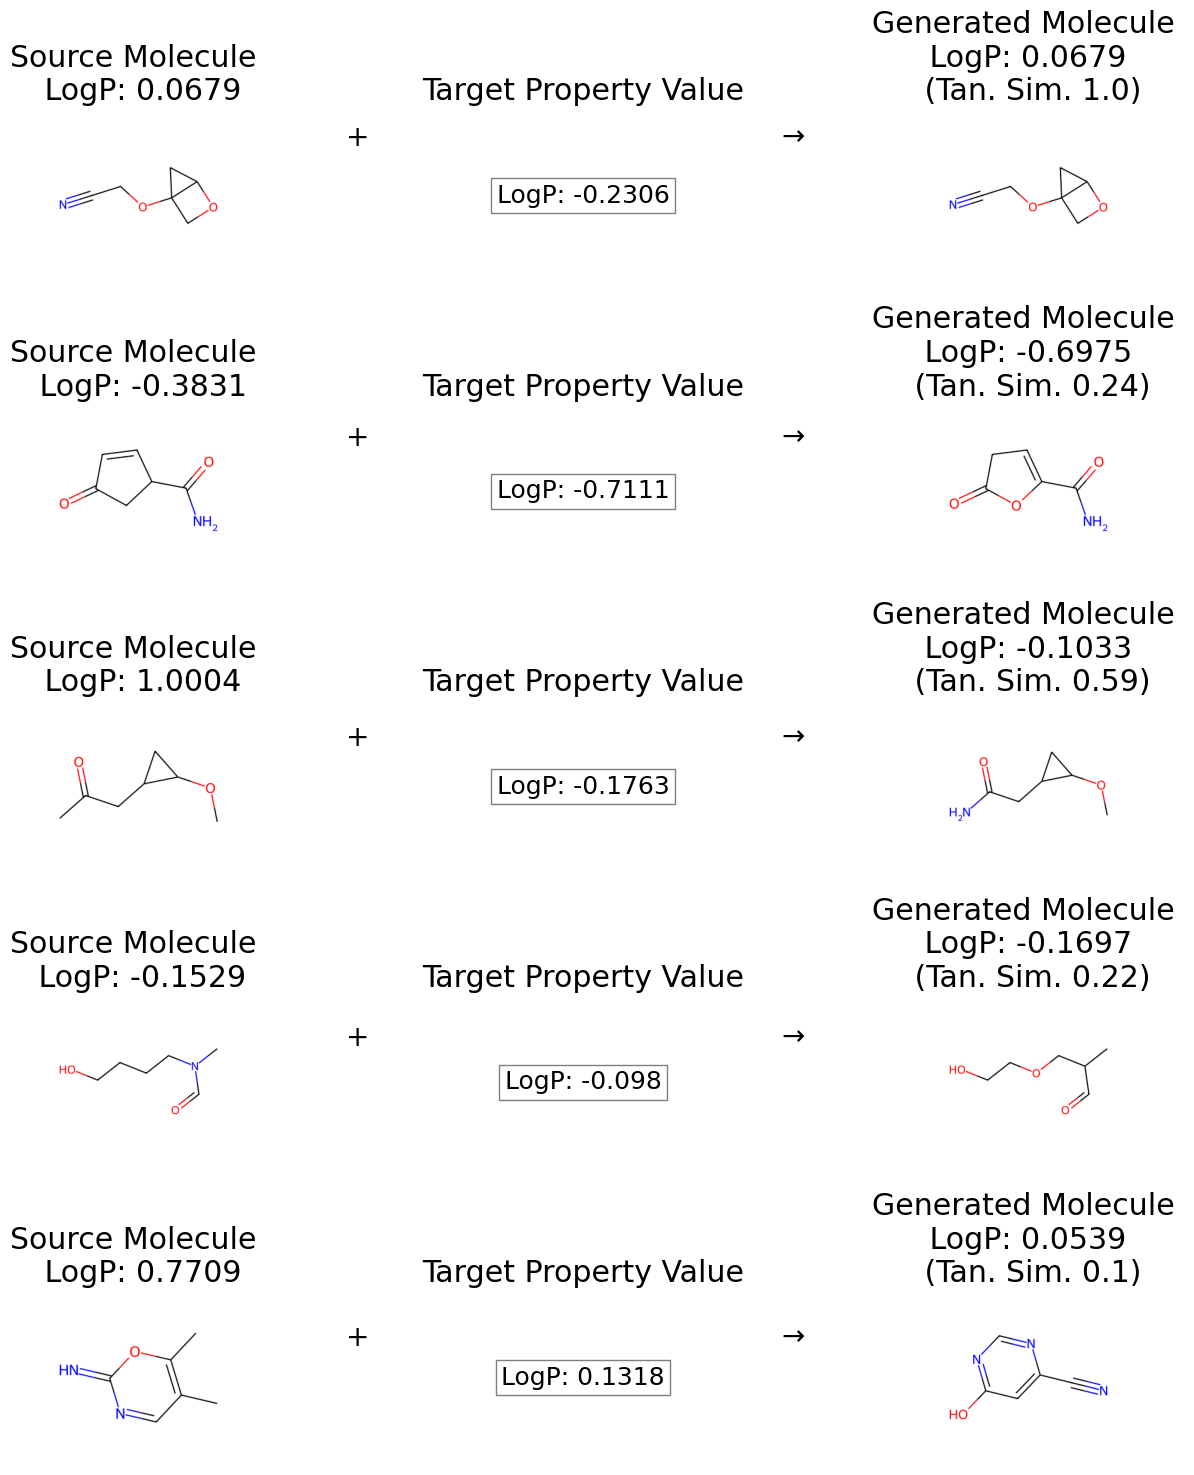

In [ ]:
# TODO: Currently this required indecies of style transfer examples be manually specified. To make it less clunky
# the code should automatically find examples where style transfer is sucesfull or performance etc...

# Indices in ST sample to plot
# NOTE: Indices corresponding to invalid ST molecules will be ignored
i1 = 2
i2 = 9
i3 = 5
i4 = 10
i5 = 4

good_source_source = [
    source_smiles[i1],
    source_smiles[i2],
    source_smiles[i3],
    source_smiles[i4],
    source_smiles[i5],
]
good_source_props = [
    source_props[i1],
    source_props[i2],
    source_props[i3],
    source_props[i4],
    source_props[i5],
]
good_target = [
    target_props[i1],
    target_props[i2],
    target_props[i3],
    target_props[i4],
    target_props[i5],
]
good_st_smiles = [
    generated_smiles[i1],
    generated_smiles[i2],
    generated_smiles[i3],
    generated_smiles[i4],
    generated_smiles[i5],
]
good_st_props = [
    generated_props[i1],
    generated_props[i2],
    generated_props[i3],
    generated_props[i4],
    generated_props[i5],
]


plot_style_transfer(
    source_smiles=good_source_source,
    source_props=good_source_props,
    target_props=good_target,
    st_smiles=good_st_smiles,
    st_props=good_st_props,
    filename=None,  # "./Selected_ST_EXP_Pol2_V5.pdf", # "./Selected_ST_EXP_Pol2_V2.pdf", # None,
    font_size=18,
    draw_tans=True,
)  # )

Plot 5 random consecutive style transfer examples from the sample of style transferred molecules.

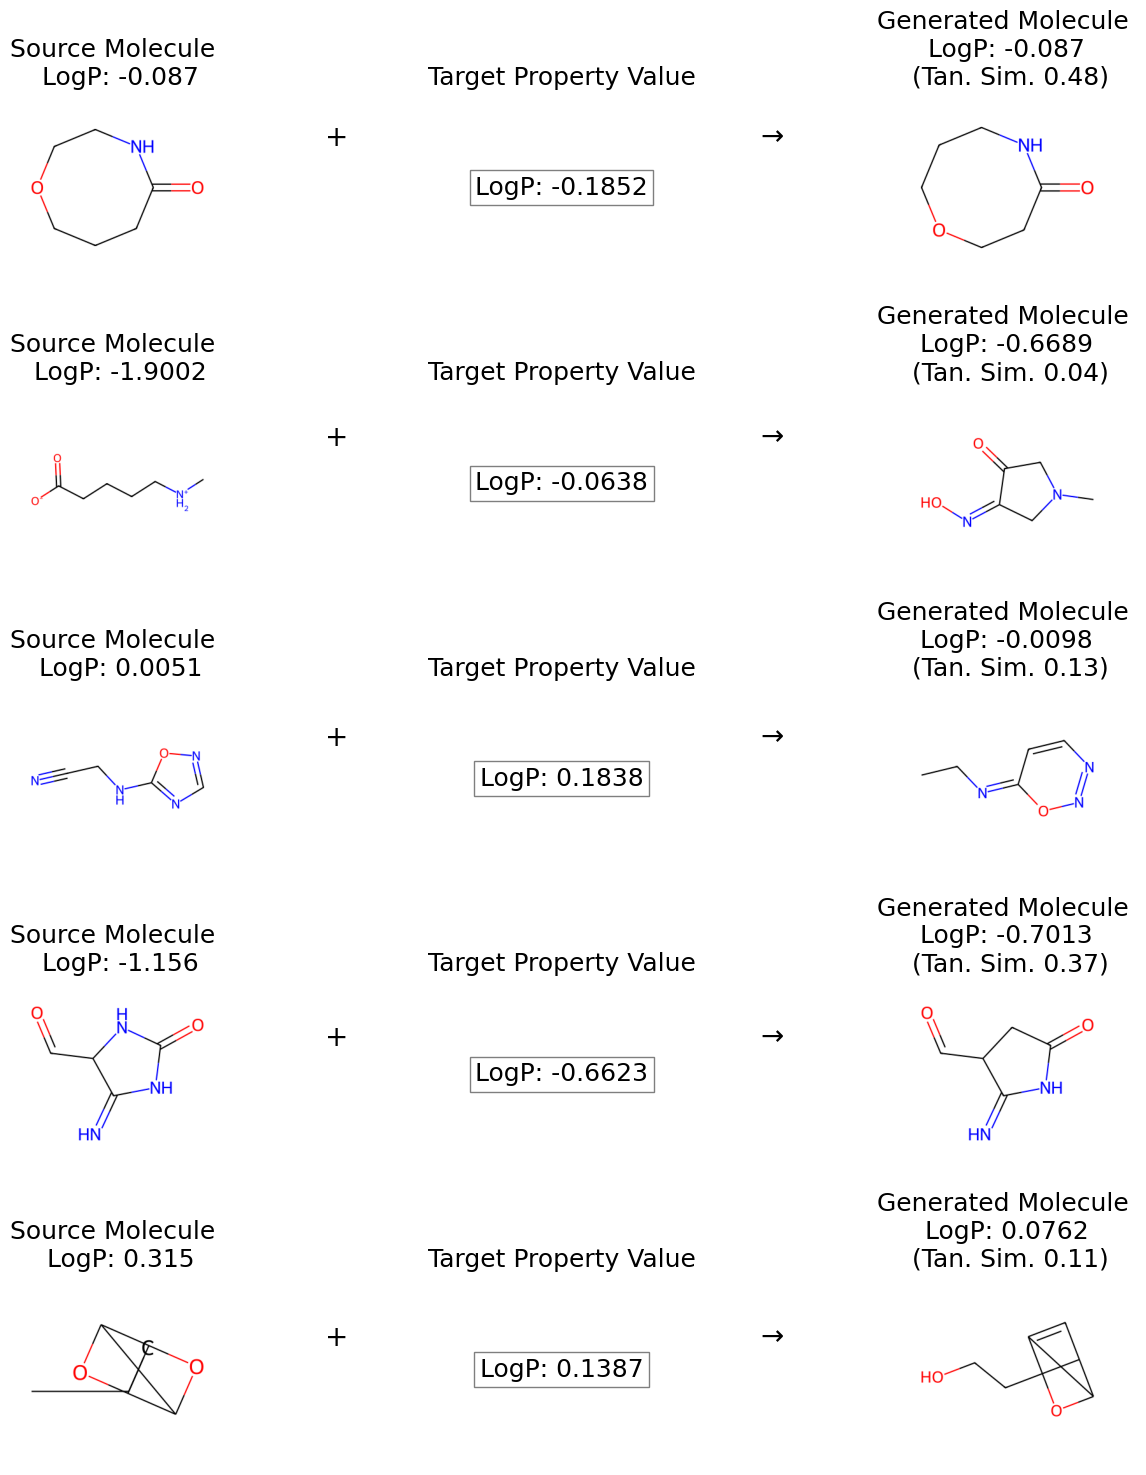

In [ ]:
n_to_plot = 5
offset = 21

plot_style_transfer(
    source_smiles=source_smiles[offset : offset + n_to_plot],
    source_props=source_props[offset : offset + n_to_plot],
    target_props=target_props[offset : offset + n_to_plot],
    st_smiles=generated_smiles[offset : offset + n_to_plot],
    st_props=generated_props[offset : offset + n_to_plot],
    filename=None,
    font_size=18,
)

### Plot Model Flexibility for Style Transfer

To visualise how good a model is at finding 'solutions' for style transfer (small changes to the source molecule that give it the desire property), we examine weather it can perform style transfer for a given source SMILES over a range of target properties. 

The following plots show a given molecule, it's original LogP value in the bottom right, and data points corresponding to the target property (x-axis) and achieved style transfer property (y-axis). An ideal model would produce the graph x=y with no missing values.

This also demonstrates:

- That it is harder to find good style transfer solutions that require a significant change in a molecules LogP value
- That model solutions correspond to different distinct "modes" (horizontal straiations on the below graphs)

Helper functions for model loading.

In [146]:
# Helper function to load a module (for explicit model types)
def load_module(file_path: str, module_name: str) -> ModuleType:
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module


# Helper function load model and sampler
def create_sampler_and_model(model_def: str, model_weights: str) -> List:
    sampler = harness_class(batch_size=64, device="cpu")
    model = load_model(
        model_class=explicit_model_class,
        model_definition=model_def,
        model_weights=model_weights,
        device="cpu",
    )
    return sampler, model


vae_module = load_module("../explicit_vae/model_vanilla_vae.py", "model_vanilla_vae")
sampler_module = load_module(
    "../explicit_vae/action_sampling_vae_sampler.py", "action_sampling_vae_sampler"
)

explicit_model_class = vae_module.VanillaMolVAE
harness_class = sampler_module.VanillaVAEHarness

Reload models, one for each type of regularizer.

In [ ]:
# ===== Explicit Models Without Teacher Forcing =====

# NOTE: Change to desired version of EXP-cVAE-KLD model
model_definit = "../models/QM9/explicit_vae/EXP-cVAE-KLD/SD_REG_VANILLA_VAE_little-math-90_Epoch_262_Vl_0.259.json"
model_weights = "../models/QM9/explicit_vae/EXP-cVAE-KLD/SD_REG_VANILLA_VAE_little-math-90_Epoch_262_Vl_0.259.pt"
exp_cvae_sampler, exp_cvae_model = create_sampler_and_model(
    model_definit, model_weights
)

# NOTE: Change to desired version of EXP-cVAE-Pol model
model_definit = "../models/QM9/explicit_vae/EXP-cVAE-Pol/SD_REG_VANILLA_VAE_winter-surf-36_Epoch_335_Vl_0.357.json"
model_weights = "../models/QM9/explicit_vae/EXP-cVAE-Pol/SD_REG_VANILLA_VAE_winter-surf-36_Epoch_335_Vl_0.357.pt"
exp_cvae_kld_sampler, exp_cvae_kld_model = create_sampler_and_model(
    model_definit, model_weights
)

# NOTE: Change to desired path EXP-cVAE-Pol2 model
model_definit = "../models/QM9/explicit_vae/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_shrill-sunset-66_Epoch_239_Vl_0.258.json"
model_weights = "../models/QM9/explicit_vae/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_shrill-sunset-66_Epoch_239_Vl_0.258.pt"
exp_cvae_pol2_sampler, exp_cvae_pol2_model = create_sampler_and_model(
    model_definit, model_weights
)

# ===== Teacher Forcing Models ======

# NOTE: Change to desired path EXP-cVAE-KLD-TF model
model_definit = "../models/QM9/explicit_vae_tf/EXP-cVAE-KLD-TF/SD_REG_VANILLA_VAE_throbbing-heart-74_Epoch_236_Vl_0.130.json"
model_weights = "../models/QM9/explicit_vae_tf/EXP-cVAE-KLD-TF/SD_REG_VANILLA_VAE_throbbing-heart-74_Epoch_236_Vl_0.130.pt"
tf_cvae_sampler, tf_cvae_model = create_sampler_and_model(model_definit, model_weights)

# NOTE: Change to desired path EXP-cVAE-Pol-TF model
model_definit = "../models/QM9/explicit_vae_tf/EXP-cVAE-Pol-TF/SD_REG_VANILLA_VAE_royal-field-57_Epoch_167_Vl_0.224.json"
model_weights = "../models/QM9/explicit_vae_tf/EXP-cVAE-Pol-TF/SD_REG_VANILLA_VAE_royal-field-57_Epoch_167_Vl_0.224.pt"
tf_cvae_kld_sampler, tf_cvae_kld_model = create_sampler_and_model(
    model_definit, model_weights
)

# NOTE: Change to desired path EXP-cVAE-Pol2-TF model
model_definit = "../models/QM9/explicit_vae_tf/EXP-cVAE-Pol2-TF/SD_REG_VANILLA_VAE_solitary-hall-80_Epoch_190_Vl_0.133.json"
model_weights = "../models/QM9/explicit_vae_tf/EXP-cVAE-Pol2-TF/SD_REG_VANILLA_VAE_solitary-hall-80_Epoch_190_Vl_0.133.pt"
tf_cvae_pol2_sampler, tf_cvae_pol2_model = create_sampler_and_model(
    model_definit, model_weights
)

a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited
a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited


/home/chrome/Code/De-Novo-Drug/De-novo-drug-design/evaluation/../lstm/rnn_utils.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_w

a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited
a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited
a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited
a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited


Generate new sample of style transfer examples.

In [80]:
# TODO: Set to desired sample size
n_samp = 500

# Ensure we have enough SMILES in test set
assert 4 * n_samp <= len(test_smiles)

# Sample random indecies from sample
all_indices = random.sample(range(len(test_smiles)), n_samp * 4)

# Sample non-overlapping indices
source_indices = all_indices[:n_samp]
target_indices = all_indices[n_samp : 2 * n_samp]
rand_dset_indices = all_indices[2 * n_samp : 3 * n_samp]
rand_dec_indices = all_indices[3 * n_samp :]

# Sample Source smiles to perform style transfer on
# source_indices = random.sample(range(len(test_smiles)), n_samp)
source_smiles = [test_smiles[i] for i in source_indices]
source_props = [test_props[i] for i in source_indices]

# Sample Target properties (and smiles) to transfer onto source molecules
# target_indices = random.sample(range(len(test_smiles)), n_samp)
target_smiles = [test_smiles[i] for i in target_indices]
target_props = [test_props[i] for i in target_indices]

# Perform Style Transfer
generated_smiles_cvae_tf = style_transfer_smiles(
    source_smiles, target_props, exp_cvae_model, exp_cvae_sampler
)

# Compute properties for style transfer results
generated_mols_cvae_tf = [Chem.MolFromSmiles(a) for a in generated_smiles_cvae_tf]
generated_props_cvae_tf = [
    None if a is None else property_calculator(a)[0] for a in generated_mols_cvae_tf
]


# Perform Style Transfer
generated_smiles_kld = style_transfer_smiles(
    source_smiles, target_props, exp_cvae_kld_model, exp_cvae_kld_sampler
)

# Compute properties for style transfer results
generated_mols_kld = [Chem.MolFromSmiles(a) for a in generated_smiles_kld]
generated_props_kld = [
    None if a is None else property_calculator(a)[0] for a in generated_mols_kld
]

/home/chrome/Code/De-Novo-Drug/De-novo-drug-design/evaluation/../explicit_vae/action_sampling_vae_sampler.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  properties = torch.tensor(properties).clone()
/home/chrome/Code/De-Novo-Drug/De-novo-drug-design/evaluation/../explicit_vae/action_sampling_vae_sampler.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_points = torch.tensor(latent_points, dtype=torch.float32)
/home/chrome/Code/De-Novo-Drug/De-novo-drug-design/evaluation/../explicit_vae/model_vanilla_vae.py:306: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rathe

Generate sample style transfer flexibility plots for 3 specific test set molecules.

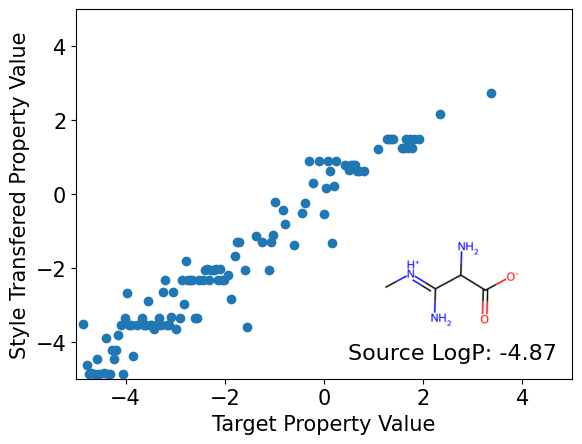

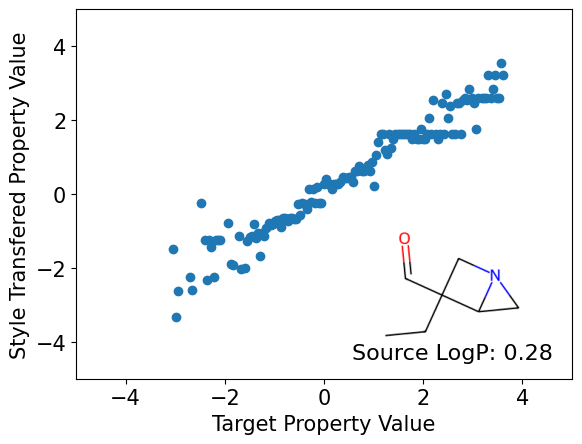

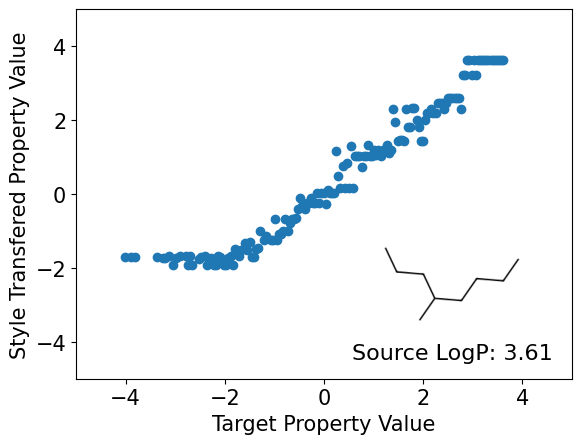

In [83]:
from rdkit.Chem import Descriptors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# NOTE: These indecies correspond to molecules with minimal, maximal and median associated property scores from the test set.
mindex = 7241
maxdex = 9117
meddex = 7883

# NOTE: Number of data points equally spaced along dataset LogP range to plot
n_points = 200

# NOTE: Select what model/regularizer version to use
mdl_name = "TF-Pol2"  # None 'KLD' 'Pol2'

for mid in ["min", "med", "max"]:
    if mdl_name is None:
        model = exp_cvae_model
        sampler = exp_cvae_sampler
    elif mdl_name == "KLD":
        model = exp_cvae_kld_model
        sampler = exp_cvae_kld_sampler
    elif mdl_name == "Pol2":
        model = exp_cvae_pol2_model
        sampler = exp_cvae_kld_sampler
    if mdl_name == "TF":
        model = tf_cvae_model
        sampler = tf_cvae_sampler
    elif mdl_name == "TF-KLD":
        model = tf_cvae_kld_model
        sampler = tf_cvae_kld_sampler
    elif mdl_name == "TF-Pol2":
        model = tf_cvae_pol2_model
        sampler = tf_cvae_kld_sampler

    if mid == "min":
        index = mindex
    if mid == "med":
        index = meddex
    if mid == "max":
        index = maxdex

    trange = np.linspace(min(test_props), max(test_props), n_points)
    tprops = torch.tensor([[a] for a in trange])

    ssmiles = np.repeat(test_smiles[index], n_points)
    gsmiles = style_transfer_smiles(ssmiles, tprops, model, sampler, b_size=64)

    # Compute properties for style transfer results
    gmols = [Chem.MolFromSmiles(a) for a in gsmiles]
    gprops = [None if a is None else property_calculator(a)[0] for a in gmols]

    if mid == "min":
        tsmi_min = test_smiles[index]
        gprops_min = gprops
    if mid == "med":
        tsmi_med = test_smiles[index]
        gprops_med = gprops
    if mid == "max":
        tsmi_max = test_smiles[index]
        gprops_max = gprops

    font_size = 18
    small_font_size = 16

    if mid == "min":
        target_smile = tsmi_min
        target_props = gprops_min
    if mid == "med":
        target_smile = tsmi_med
        target_props = gprops_med
    if mid == "max":
        target_smile = tsmi_max
        target_props = gprops_max

    molecule = Chem.MolFromSmiles(target_smile)

    # Calculate LogP
    logP = Descriptors.MolLogP(molecule)

    # Create larger molecular image
    # WARNING: Availability depends on version of RdKit
    # from rdkit.Chem.Draw import DrawingOptions
    # DrawingOptions.bondLineWidth = 100.0

    molecular_image = Draw.MolToImage(molecule, size=(200, 200))  # Increase the size

    # molecular_image = mol_to_image_with_thick_lines(molecule)
    # Create scatter plot
    fig, ax = plt.subplots()

    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)

    ax.scatter(trange, target_props)
    ax.set_xlabel("Target Property Value")
    ax.set_ylabel("Style Transfered Property Value")
    # ax.set_title('Style Transfer performance for Target Property Range')

    # Create inset axis for the molecular image
    inset_ax = inset_axes(
        ax, width="40%", height="40%", loc="lower right", borderpad=1
    )  # Adjust width and height
    inset_ax.text(
        0.5,
        0.1,
        f"Source LogP: {logP:.2f}",
        fontsize=small_font_size,
        ha="center",
        va="top",
        transform=inset_ax.transAxes,
    )

    # Display molecular image in the inset axis
    inset_ax.imshow(molecular_image)
    inset_ax.axis("off")

    if mid == "min":
        min_logp = logP
        fig_min = fig
        ax_min = ax
        min_image = molecular_image
    if mid == "med":
        med_logp = logP
        fig_med = fig
        ax_med = ax
        med_image = molecular_image
    if mid == "max":
        max_logp = logP
        fig_max = fig
        ax_max = ax
        max_image = molecular_image

Combine individual molecule plots. 

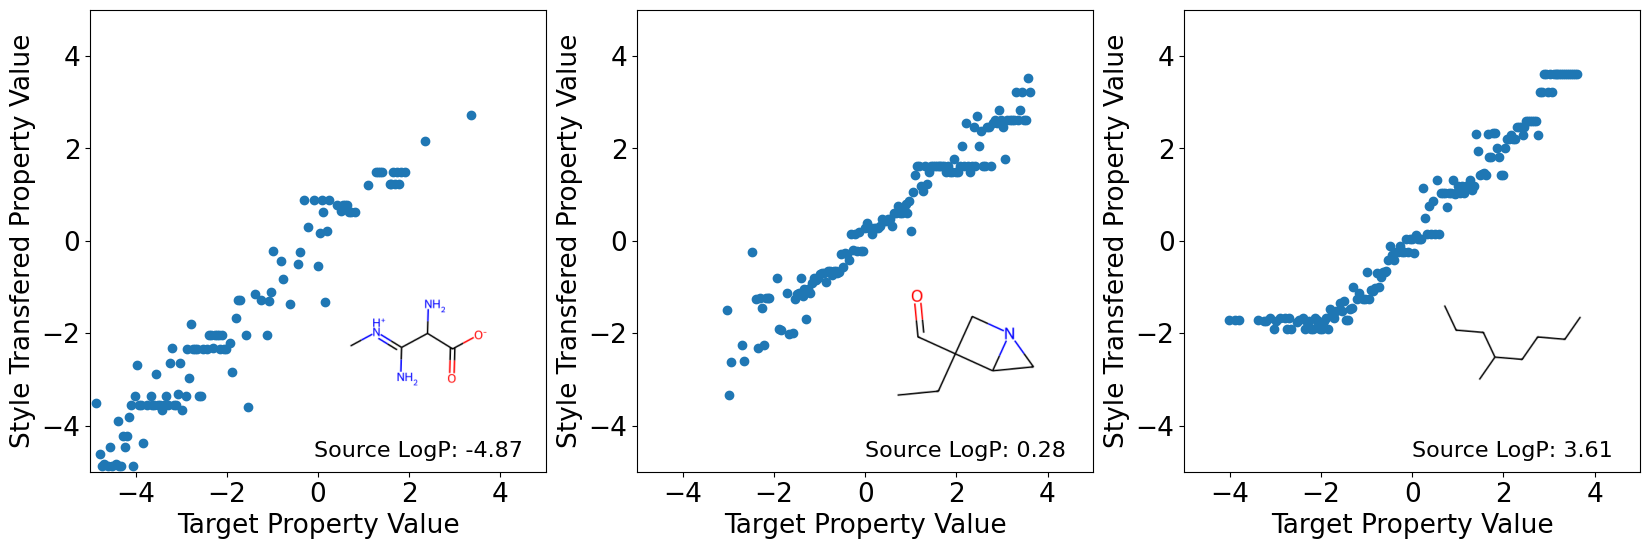

In [ ]:
prop_arrays = [gprops_min, gprops_med, gprops_max]
mimages = [min_image, med_image, max_image]
logps = [min_logp, med_logp, max_logp]

fig_title = "ST_Range_TF-cVAE-Pol2_V5.pdf"  # 'ST_Range_EXP-cVAE-KLD.pdf' # None # 'ST_Range_EXP-cVAE.pdf'

plt.rcParams.update({"font.size": font_size + 1})

# Create a new figure with 1 row and 3 columns for subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Plot each figure in the subplots
for i in range(3):
    axs[i].scatter(trange, prop_arrays[i], zorder=2)
    axs[i].set_xlabel("Target Property Value")
    axs[i].set_ylabel("Style Transfered Property Value")
    # axs[i].set_title('Style Transfer performance for various properties')
    axs[i].set_xlim(-5, 5)
    axs[i].set_ylim(-5, 5)

    # Toggle width and height
    inset_ax = inset_axes(
        axs[i], width="33%", height="33%", loc="lower right", borderpad=2.0
    )
    inset_ax.imshow(mimages[i])
    inset_ax.axis("off")  # Hide the axis
    inset_ax.text(
        0.5,
        -0.15,
        f"Source LogP: {logps[i]:.2f}",
        fontsize=small_font_size,
        ha="center",
        va="top",
        transform=inset_ax.transAxes,
    )


# Show the combined figure with horizontally stacked plots
if fig_title is None:
    plt.show()
else:
    plt.savefig(fig_title)

## Evaluate LSTM (Surrogate) Model Performance

Evaluate the performance of the surrogate LSTM model used to guide cVAE through regularizers.

In [85]:
# Load model
lstm_definit = "../models/QM9/surrogate/lstm_qm9_12_1.180.json"
lstm_params = "../models/QM9/surrogate/lstm_qm9_12_1.180.pt"

# lstm_sampler = FastSampler(device = 'cpu', batch_size=64)
lstm_sampler = ConditionalSmilesRnnSampler(device="cpu", batch_size=128)
lstm_model = load_rnn_model(
    model_definition=lstm_definit,
    model_weights=lstm_params,
    device="cpu",
)

/home/chrome/Code/De-Novo-Drug/De-novo-drug-design/evaluation/../lstm/rnn_utils.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_w

Sample a set of 10 molecules from surrogate lstm model.

In [ ]:
results = lstm_sampler.sample(
    model=lstm_model, properties=[[a] for a in test_props[:10]], num_to_sample=10
)

for i in range(len(results)):
    print(f"SMILES {i}: " + results[i])

SMILES 0: N=COCCCCC=O
SMILES 1: C1NC23COC1C2CO3
SMILES 2: CCC1C(C)N1C(N)=O
SMILES 3: CC(C#N)C1(C)CC1
SMILES 4: CNc1cc2n(n1)CC2
SMILES 5: O=C(CO)C(F)(F)F
SMILES 6: CC1C2CCC(O2)C1O
SMILES 7: COC1C=C(CO)CC1
SMILES 8: CC1(O)CCOCOC1
SMILES 9: O=C([O-])C1C=CC([NH3+])O1


/home/chrome/Code/De-Novo-Drug/De-novo-drug-design/evaluation/../lstm/action_sampler.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(actions)


**NOTE: Make sure correct dataset was loaded earlier**

Compute generative performance metrics for surrogate model. Metric definition is the same as for the cVAE evaluation when sampling from the prior. 

In [144]:
def compute_metrics_lstm(
    lstm_sampler,
    lstm_model: torch.nn.Module,
    target_props: Union[List[float], np.ndarray],
    train_smiles: Union[List[str], np.ndarray],
    property_calculator: PropertyCalculator,
    seq_len: int = 120,
) -> Dict[str, float]:
    """
    Sample a set of points from the surrogate model and compute the sample validity, uniqueness, noevelty and property error.
    The sample size is determined by the length of target_props and train_smiles.

    Args:
        lstm_sampler (Sampler): Standard LSTM sampler implementing .sample().
        lstm_model (nn.Module): Standard LSTM model.
        target_props (list[float]): List of training set properties to use as conditional information.
        train_smiles (list[str]): List of training set SMILES.
        property_calculator (PropertyCalculator): Property calculator utility object
        seq_len (int): Sequence length up to which to decode from the LSTM.

    Returns:
        dict:
            {
                'validity': float,
                'uniqueness': float,
                'novelty': float,
                'MAE': float
            }

    """

    # Generate sample from the LSTM
    sample_smiles = lstm_sampler.sample(
        model=lstm_model,
        properties=target_props.clone(),
        num_to_sample=len(target_props),
        max_seq_len=seq_len,
    )

    # assert len(sample_smiles) == len(target_props)

    # Initialize counters
    n_decodes = 0
    n_valid = 0
    n_valid_in_train = 0
    unique_valid = set()
    total_me = 0.0

    # Train set for novelty computation
    train_set = set(train_smiles)

    for i in range(len(sample_smiles)):
        n_decodes += 1
        smi = sample_smiles[i]
        prop = target_props[i]

        # Attempt to parse generated SMILES
        mol = Chem.MolFromSmiles(smi)

        # If the molecule was sucesfully parsed by RdKit
        if mol is not None:
            n_valid += 1
            can_smi = Chem.MolToSmiles(mol, canonical=True)
            unique_valid.add(can_smi)

            total_me += abs(property_calculator(mol)[0] - prop)

            # Check if in train set
            if can_smi in train_set:
                n_valid_in_train += 1

    # Compute metric estimates
    validity = n_valid / n_decodes
    uniqueness = len(unique_valid) / n_valid
    novelty = (n_valid - n_valid_in_train) / n_valid
    mae = total_me / n_valid

    return {
        "Validity": validity,
        "Uniqueness": uniqueness,
        "Novelty": novelty,
        "Property MAE": float(mae[0]),
    }

For the surrogate model, the property scores need to be normalized manually, else they would be normalized twice when the sampler is called from the cVAE training loop. Select a sample of target properties and normalize them.

In [89]:
# NOTE: Set sample size
samp_size = 300

target_props = random.choices(test_props, k=samp_size)

all_y = np.concatenate((test_props, val_props), axis=0)
mean = np.mean(all_y, axis=0)
print(f"Normalizing Mean: {mean}")
std = np.std(all_y, axis=0)
print(f"Normalizing STD: {std}")
# np.save(data_path + '/normalizer.py', [mean, std])
target_props_normed = (target_props - mean) / std
target_props_normed = torch.tensor(
    [[a] for a in target_props_normed], dtype=torch.float32
)

Normalizing Mean: 0.29867047750000003
Normalizing STD: 0.9960265062292806


In [90]:
# sampled_smiles = lstm_sampler.sample(model=lstm_model, properties=target_props_normed, num_to_sample=len(target_props), max_seq_len=120)
results = compute_metrics_lstm(
    lstm_sampler,
    lstm_model,
    train_smiles=train_smiles,
    target_props=target_props_normed,
    property_calculator=property_calculator,
)

print("===== Surrogate Generative Performance Metrics =====")
for key, value in results.items():
    print(f"{key}: {value}")

===== Surrogate Generative Performance Metrics =====
Validity: 0.9833333333333333
Uniqueness: 1.0
Novelty: 0.22372881355932203
Property MAE: 0.31888100504875183


## Compute Property Score Error Baseline

Estimate the mean property error for random pairs of test set properties. This serves as an upper bound on the achieved property error representing a case where the model completely ignores conditioning property information and has learned to perfectly model the empirical distribution using the latent information z.  

In [147]:
def mean_absolute_error(
    list1: Union[List[float], np.ndarray], list2: Union[List[float], np.ndarray]
) -> float:
    """
    Compute the MAE between two lists of floats

    Args:
        list1 (list[float]): List of property score floats
        list2 (list[float]): List of property score floats

    Returns:
        (float): The MAE between the two lists
    """

    if len(list1) != len(list2):
        raise ValueError("Lists must have the same length")

    mae = sum(abs(a - b) for a, b in zip(list1, list2)) / len(list1)
    return mae

Estimate upper bound property MAE.

In [92]:
propsA = test_props
propsB = random.sample(list(test_props), len(test_props))

mse = mean_absolute_error(propsA, propsB)
print(f"Baseline MAE is: {mse}")

Baseline MAE is: 1.1089111319999998


Compute the SD for properties.

In [93]:
mean = np.mean(test_props)
propsMean = [mean for _ in range(len(test_props))]

mse = mean_absolute_error(propsMean, propsA)
print(f"Property SD is: {mse}")

Property SD is: 0.7824948856239986


Using joblib to parralelize computation it is feasible to compute the mean difference between each possible test set pair of properties.

In [ ]:
def pairwise_distance(
    properties: Union[List[float], np.ndarray], i: int, j: int
) -> float:
    return np.abs(properties[i] - properties[j])


def average_distance_with_tqdm_parallel(
    properties: Union[List[float], np.ndarray], n_jobs: int = -1
) -> float:
    properties = np.array(properties)
    num_properties = len(properties)

    if num_properties < 2:
        return 0.0

    # Create a list of index pairs for which distances need to be calculated
    index_pairs = [
        (i, j) for i in range(num_properties) for j in range(i + 1, num_properties)
    ]

    # Use joblib to calculate distances in parallel
    distances = Parallel(n_jobs=n_jobs)(
        delayed(pairwise_distance)(properties, i, j) for i, j in tqdm(index_pairs)
    )

    average_distance = np.mean(distances)

    return average_distance


average_distance_with_tqdm_parallel(test_props)

## Additional Plots

Code to generate some additional plots used in the paper and final report. 

### Plot Samples of Generated Molecules

**Visualise Train Set Sample:** Plot a sample of molecules from the train set. This is the baseline distribution the model is trying to model.

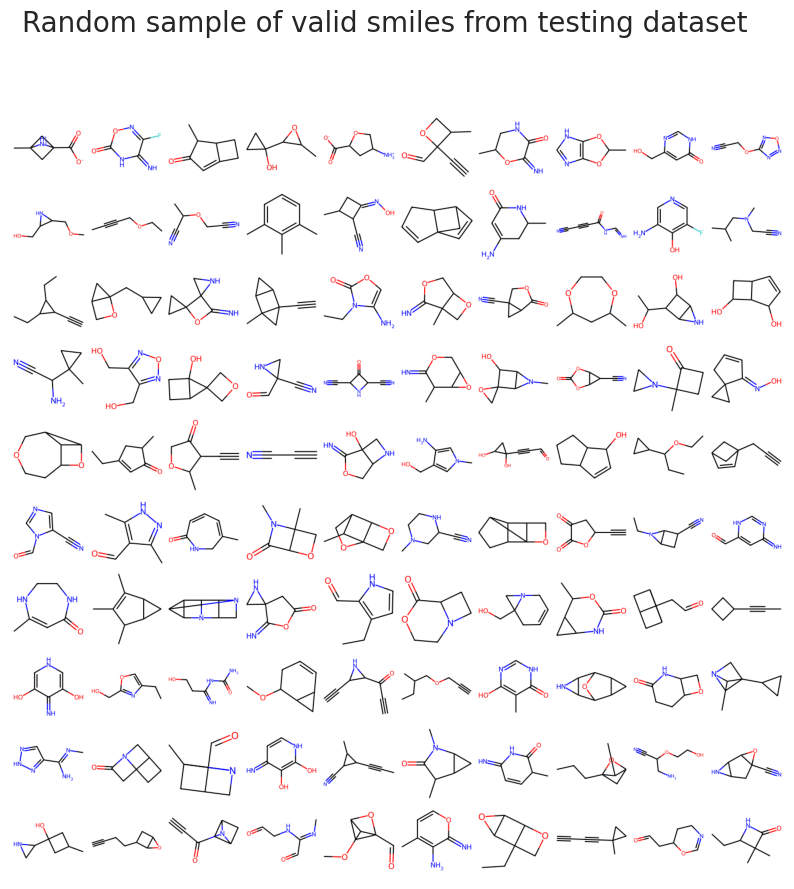

In [149]:
indecies = random.sample(range(len(test_props)), 101)
train_samp_smiles = [test_smiles[i] for i in indecies]

plot_smiles(
    train_samp_smiles, title="Random sample of valid smiles from testing dataset"
)

**Visualise Surrogate LSTM Sample**: Plot sample of molecules sampled from LSTM model with random latent points and test set conditioning properties.

**TODO:** Because of how the LSTM handles maximal sequence lengths and input properties the sampler interface ended up slightly different from that of the cVAE models. This should be changed so that the two models can be used in evaluation code interchangably.

Sampling LSTM Model with Random Uniform Targets


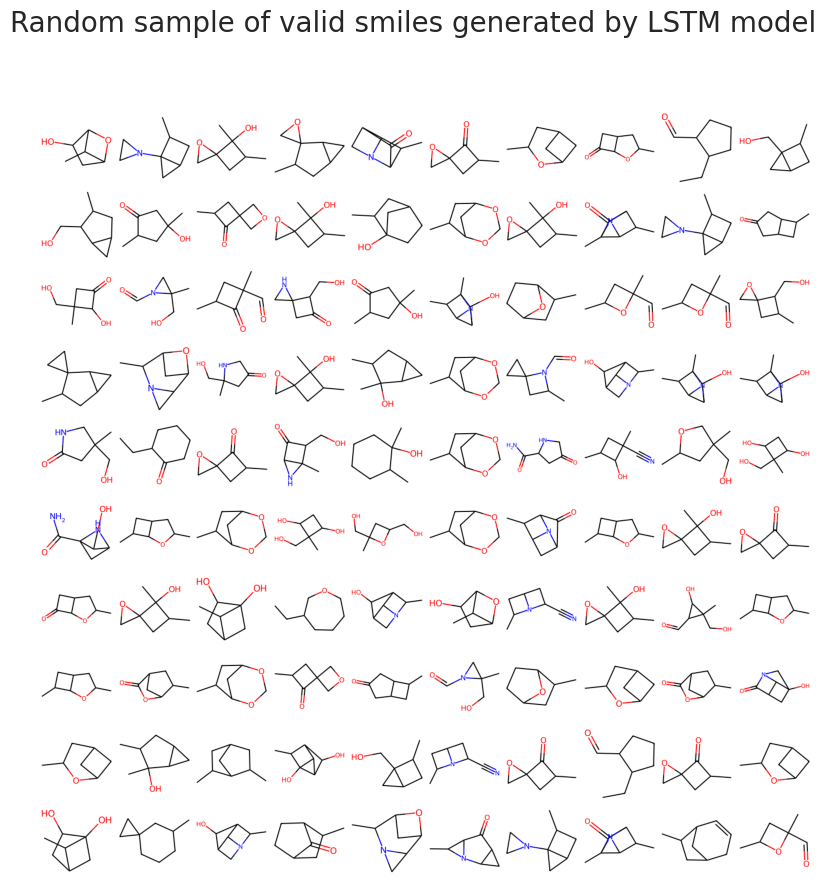

In [164]:
# NOTE: Set sample size, model and model name
model = lstm_model
sampler = lstm_sampler
samp_size = 300  # Should be sufficient for high validity LSTM models to generate at least 100 valid SMILES for the plot

# Sample properties
indecies = random.sample(range(len(test_props)), samp_size)
# samp_props = [test_props[i] for i in indecies]
samp_props = torch.tensor([[test_props[i]] for i in indecies], dtype=torch.float)

print("Sampling LSTM Model with Random Uniform Targets")
lstm_global_sample_smiles = sampler.sample(
    model=model, properties=samp_props, num_to_sample=samp_size
)
# assert(len(lstm_global_sample_smiles) == samp_size)

# Plots 100 molecules in a 10 by 10 grid
plot_smiles(
    lstm_global_sample_smiles,
    title="Random sample of valid smiles generated by LSTM model",
)

**Visualise cVAE Model Sample**: Plot sample of molecules sampled from a (un/regularized) cVAE model with random latent points and test set conditioning properties.

Sampling cVAE Model with Random Uniform Targets


/home/chrome/Code/De-Novo-Drug/De-novo-drug-design/evaluation/../vae/model_vanilla_vae_short.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()


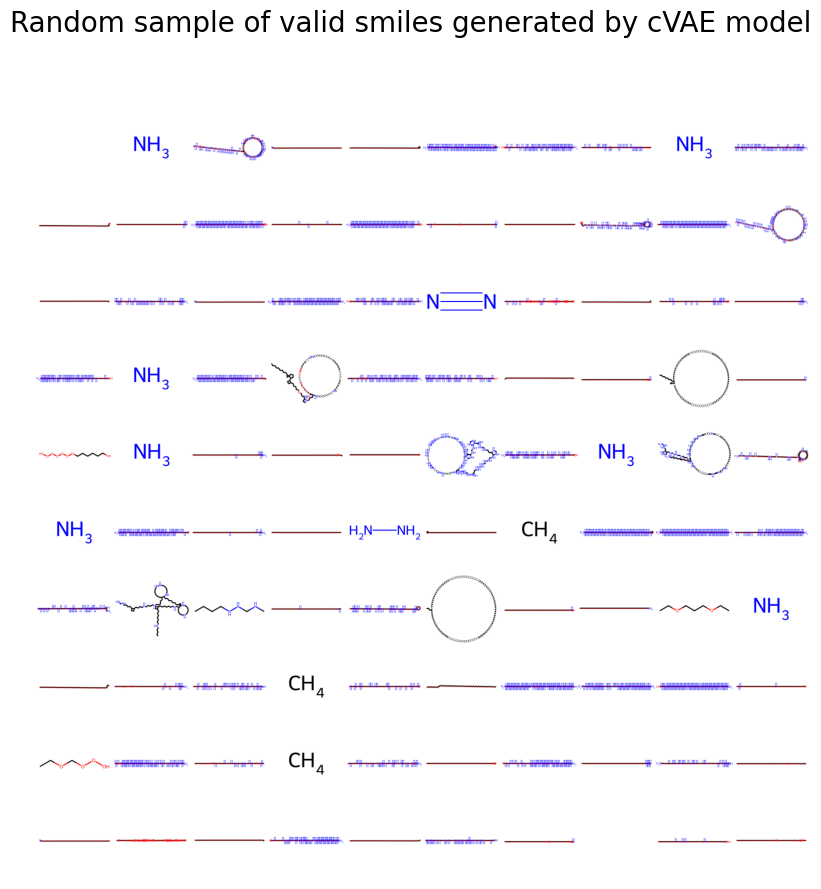

In [ ]:
# NOTE: Set model and model name. Currently used model used for performance evaluation benchmarks earlier in this notebook
model = cvae_model
sampler = cvae_sampler
model_name = "cVAE"
samp_size = 3000  # To sucesfully plot we need a sample containing at least 100 valid SMILES. This number may need to be set higher.

# Sample properties
indecies = random.sample(range(len(test_props)), samp_size)
samp_props = [[test_props[i]] for i in indecies]

print(f"Sampling {model_name} Model with Random Uniform Targets")
cvae_global_sample_smiles = sampler.sample(model=model, properties=samp_props)


plot_smiles(
    cvae_global_sample_smiles,
    title=f"Random sample of valid smiles generated by {model_name} model",
)

### Examine Model Generative Distribution of Property Scores Compared to Dataset

Examine weather the model has properly modelled the distribution of property values in the dataset

100%|██████████| 1000/1000 [00:00<00:00, 4100.51it/s]


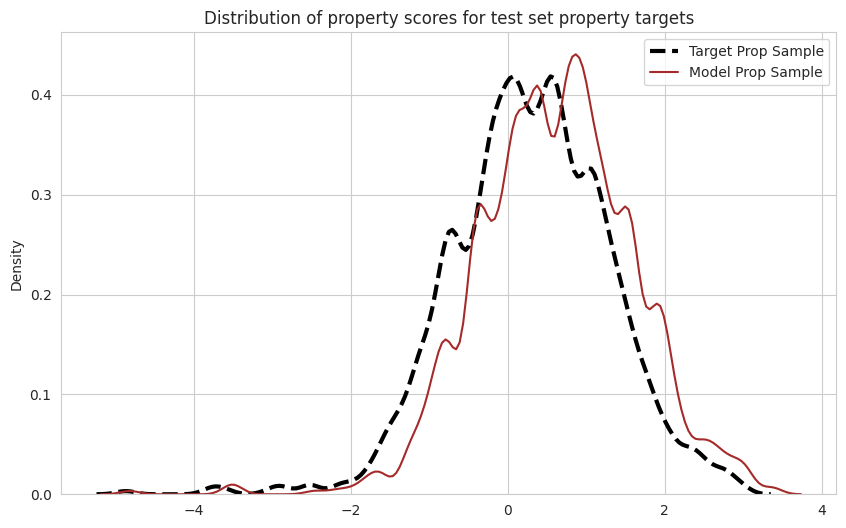

In [ ]:
# NOTE: Set desired sample size and select model
sample_size = 1000
model = lstm_model  # cvae_model
sampler = lstm_sampler  # cvae_sampler


indices = random.sample(range(len(test_props)), sample_size)
props_targets = [test_props[i] for i in indices]

# HACK: Workaround for sampler interface difference between LSTM and cVAE
try:
    smiles_generated = sampler.sample(
        model, torch.tensor([[a] for a in props_targets], dtype=torch.float32)
    )
except TypeError:
    smiles_generated = sampler.sample(
        model,
        torch.tensor([[a] for a in props_targets], dtype=torch.float32),
        num_to_sample=len(props_targets),
    )

props_generated = props_from_smiles(smiles_generated)

plt.figure(figsize=(10, 6))

sns.kdeplot(
    props_targets,
    color="black",
    label="Target Prop Sample",
    bw_adjust=0.5,
    linestyle="--",
    linewidth=3,
)
sns.kdeplot(props_generated, color="brown", label="Model Prop Sample", bw_adjust=0.5)

plt.title(
    "Distribution of property scores for test set property targets"
)  # {pval0} : {pval1})')
plt.legend()
plt.show()

### Plot Model Performance Changes Over Range Target Property Values

Examine how well the model handles target properties from the edge or outside the training set support.

In [102]:
# NOTE: Set range and density of target property steps
property_steps = np.arange(-3, 3, 0.5)
samp_per_step = 500

# NOTE: Select model to use.
range_sampler = lstm_sampler  # cvae_sampler
range_model = lstm_model  # cvae_model

In [174]:
def return_valid_smiles(smiles_list: List[str]) -> List[str]:
    """
    Utility function to remove invalid smiles from smiles list

    Args:
        smiles_list (list[str]): list of smiles
    Returns:
        (list[str]): list of smiles with invalid smiles removed

    """
    valid = []

    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            valid.append(smi)
    return valid

In [177]:
# Track performance metrics over the range of values
model_pstep_smiles = {"validity": [], "unique_pct": [], "novelty": []}

model_steps_properties = []

model_steps_stats = {"Failed to decode": [], "Invalid Smiles": [], "Valid": []}
model_steps_properties = []

# Iterate over property steps
for p_val in tqdm(property_steps):
    # Generate sample for given property step and compute proportion invalid smiles
    props = torch.Tensor([[p_val] for i in range(samp_per_step)])

    # HACK: Workaround for difference in LSTM and cVAE sampler interface
    try:
        smiles = range_sampler.sample(model=range_model, properties=torch.Tensor(props))
    except TypeError:
        smiles = range_sampler.sample(
            model=range_model,
            properties=torch.Tensor(props),
            num_to_sample=samp_per_step,
        )

    missing = samp_per_step - len(smiles)
    valid_smiles = return_valid_smiles(smiles)
    invalid = (samp_per_step - missing) - len(valid_smiles)
    properties = props_from_smiles(valid_smiles)

    # Compute performance metrics and handle case where no valid smiles generated
    try:
        valid, uniq, novel = amina_metrics(smiles, props)
    except ZeroDivisionError:
        valid = 0.0
        uniq = 0.0
        novel = 0.0

    # Store results
    model_pstep_smiles["validity"].append(valid)
    model_pstep_smiles["unique_pct"].append(uniq)
    model_pstep_smiles["novelty"].append(novel)

    model_steps_properties.append(properties)
    model_steps_stats["Failed to decode"].append(missing)
    model_steps_stats["Invalid Smiles"].append(invalid)
    model_steps_stats["Valid"].append(samp_per_step - missing - invalid)


100%|██████████| 457/457 [00:00<00:00, 5263.47it/s]

100%|██████████| 471/471 [00:00<00:00, 5200.96it/s]

100%|██████████| 487/487 [00:00<00:00, 5339.77it/s]


100%|██████████| 489/489 [00:00<00:00, 4541.21it/s]

100%|██████████| 492/492 [00:00<00:00, 5212.05it/s]

100%|██████████| 489/489 [00:00<00:00, 5033.55it/s]

100%|██████████| 489/489 [00:00<00:00, 5039.57it/s]


100%|██████████| 490/490 [00:00<00:00, 4488.32it/s]


100%|██████████| 490/490 [00:00<00:00, 4087.68it/s]


100%|██████████| 493/493 [00:00<00:00, 4467.14it/s]

100%|██████████| 496/496 [00:00<00:00, 5383.05it/s]

100%|██████████| 12/12 [01:05<00:00,  5.47s/it]


**Plot Validity, Uniqueness and Novelty Across Range**

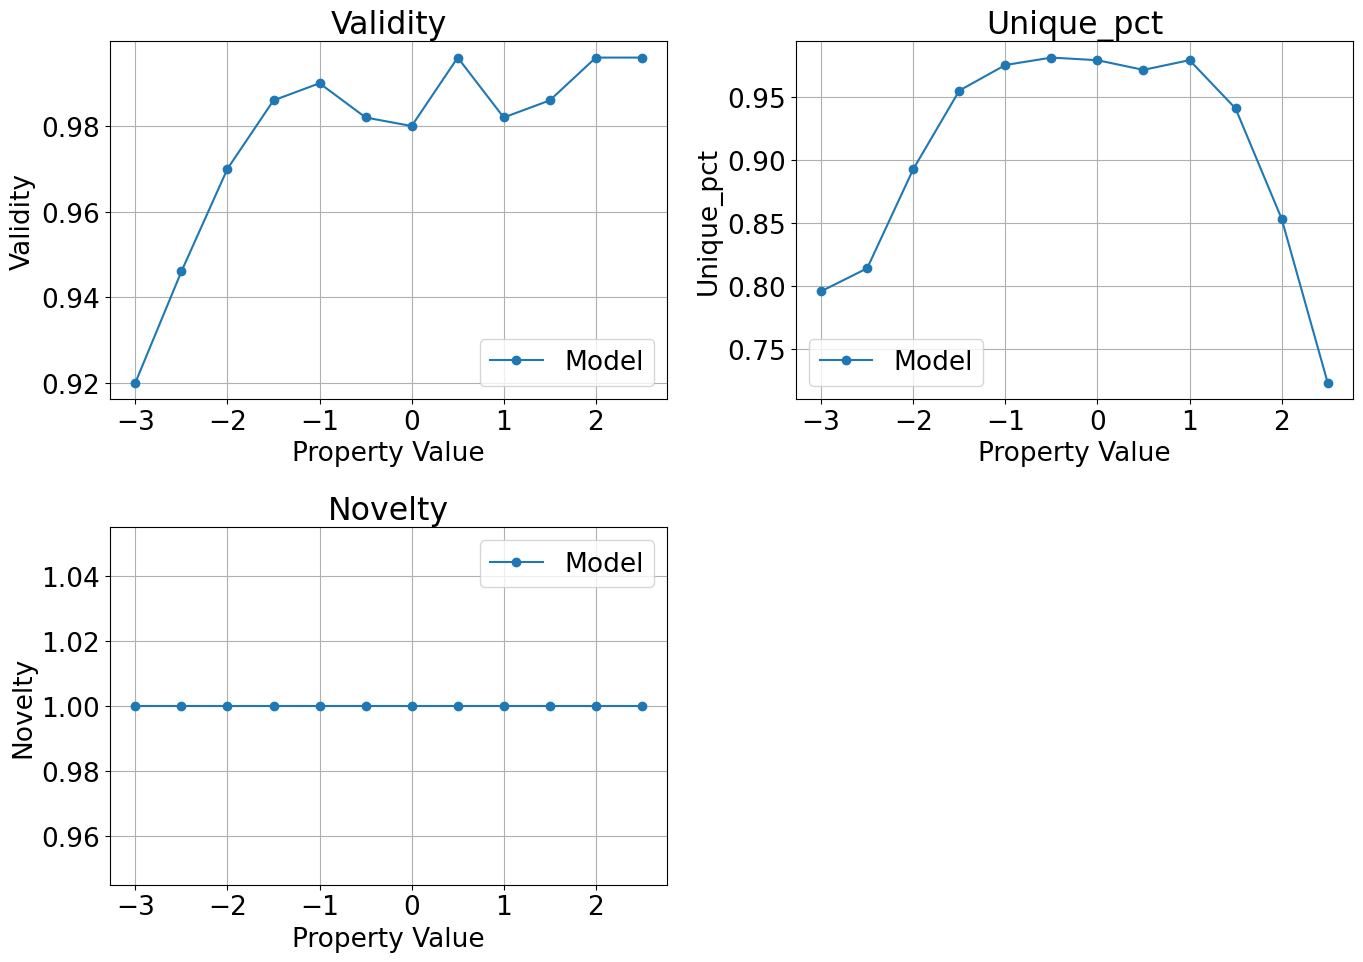

In [ ]:
# Assume we have properties for both models in sd_lstm_pstep_smiles and lstm_pstep_smiles
keys = ["validity", "unique_pct", "novelty"]

plt.figure(figsize=(14, 10))

for i, key in enumerate(keys, 1):
    plt.subplot(2, 2, i)
    plt.plot(
        property_steps,
        model_pstep_smiles[key],
        label="Model",
        marker="o",
        linestyle="-",
    )

    plt.title(key.capitalize())
    plt.xlabel("Property Value")
    plt.ylabel(key.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

**Examine Targeting Performance Across Range**

For each step in the range, check the distribution of attained property scores for that target. The tighter the distribution the better.

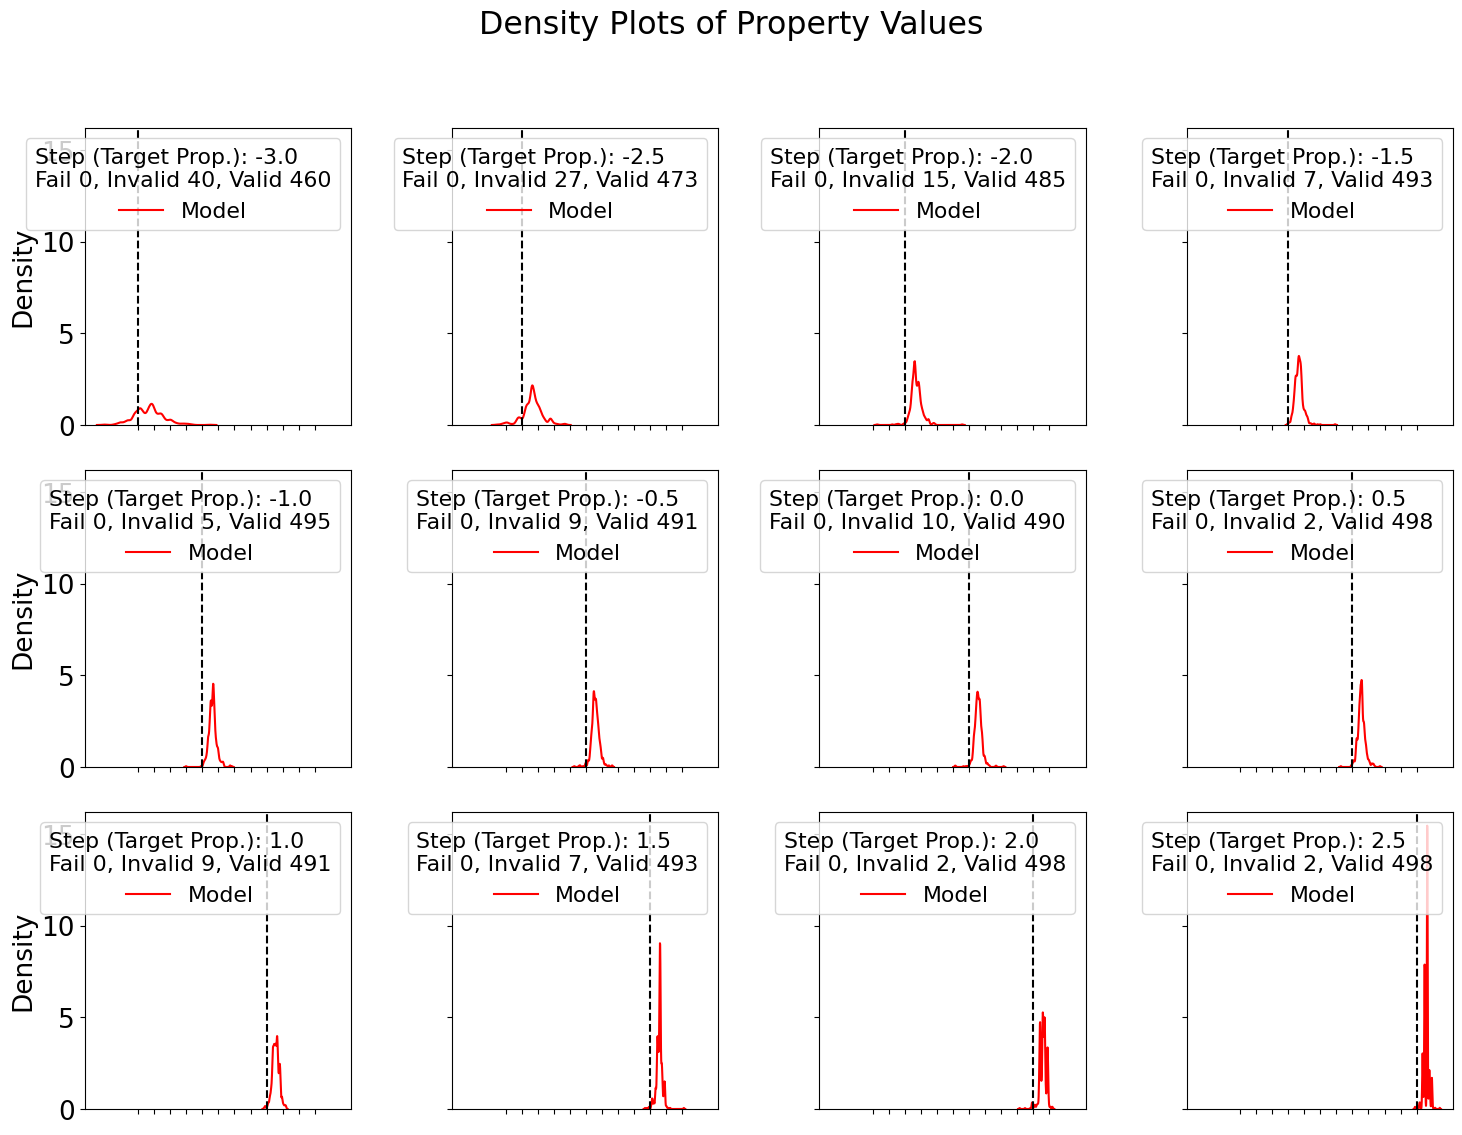

In [ ]:
# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)
fig.suptitle("Density Plots of Property Values")

# Flatten the axes for easy iteration
axes_flat = axes.flatten()

# Loop through each property step and create the corresponding plot
for i, p_val in enumerate(property_steps):
    ax = axes_flat[i]

    if model_steps_properties[i]:
        sns.kdeplot(
            model_steps_properties[i], ax=ax, color="red", label="Model", bw_adjust=0.5
        )

    # Vertical line for the target property value
    ax.axvline(x=p_val, color="black", linestyle="--")

    ax.set_xticks(property_steps)

    # Adding legend with dynamic title
    ax.legend(
        title=f'Step (Target Prop.): {p_val}\nFail {model_steps_stats["Failed to decode"][i]}, Invalid {model_steps_stats["Invalid Smiles"][i]}, Valid {model_steps_stats["Valid"][i]}',
        loc="upper right",
        fontsize="small",
        title_fontsize="small",
    )

    # Setting labels for each subplot
    ax.set_xlabel("Property Value")
    ax.set_ylabel("Density")

# Hide any unused subplots
for j in range(i + 1, 16):
    fig.delaxes(axes_flat[j])

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle

# Show the plot
plt.show()

### Plots Examining the Effect of Introducing the Regularizer

Compare the performance of the vanilla cVAE model, explicit cVAE model, (best) regularized cVAE model and LSTM Surrogate. 

In [107]:
# Reload models for comparison
# TODO: Clean up loading code for this section

# ===== Surrogate LSTM Model =====
# NOTE: Select desired model path
lstm_model_path = "../models/QM9/surrogate/"
lstm_definition_fname = "lstm_qm9_12_1.180.json"
lstm_weights_fname = "lstm_qm9_12_1.180.pt"

lstm_sampler = FastSampler(device="cpu", batch_size=64)
lstm_model = load_rnn_model(
    model_definition=os.path.join(lstm_model_path, lstm_definition_fname),
    model_weights=os.path.join(lstm_model_path, lstm_weights_fname),
    device="cpu",
)

with open(os.path.join(lstm_model_path, lstm_definition_fname)) as pfile:
    model_params = json.load(pfile)

lstm_mpar = model_params["property_names"]
print(f"Loaded cLSTM Conditioned on Following Props: {lstm_mpar}")

# ===== One-Shot cVAE Model =====
# NOTE: Select desired model path
device = "cpu"
model_weights = "../models/QM9/vae/cVAE/cVAE_odd-wind-32_Epoch_310_Vl_0.114.pt"
model_definit = "../models/QM9/vae/cVAE/cVAE_odd-wind-32_Epoch_310_Vl_0.114.json"

cvae_sampler = VanillaVAEHarness(batch_size=64, device="cpu")
cvae_model = load_model(
    model_class=VanillaMolVAE,
    model_definition=model_definit,
    model_weights=model_weights,
    device="cpu",
)

cvae_model = cvae_model.to(device)
cvae_model.device = device
cvae_model.encoder.device = device
cvae_model.state_decoder.device = device

print("Loaded One-Shot cVAE")


# ===== Explicit Regularized cVAE Model =====
# NOTE: Select desired model path
model_weights = "../models/QM9/explicit_vae/EXP-cVAE-KLD/SD_REG_VANILLA_VAE_little-math-90_Epoch_262_Vl_0.259.pt"
model_definit = "../models/QM9/explicit_vae/EXP-cVAE-KLD/SD_REG_VANILLA_VAE_little-math-90_Epoch_262_Vl_0.259.json"

file_path = "../explicit_vae/model_vanilla_vae.py"
spec = importlib.util.spec_from_file_location("model_vanilla_vae.py", file_path)
module = importlib.util.module_from_spec(spec)
sys.modules["model_vanilla_vae"] = module
spec.loader.exec_module(module)
explicit_model_class = module.VanillaMolVAE

file_path = "../explicit_vae/action_sampling_vae_sampler.py"
spec = importlib.util.spec_from_file_location(
    "action_sampling_vae_sampler.py", file_path
)
module = importlib.util.module_from_spec(spec)
sys.modules["action_sampling_vae_sampler"] = module
spec.loader.exec_module(module)

harness_class = module.VanillaVAEHarness

reg_exp_cvae_sampler = harness_class(batch_size=64, device="cpu")
reg_exp_cvae_model = load_model(
    model_class=explicit_model_class,
    model_definition=model_definit,
    model_weights=model_weights,
    device="cpu",
)

print("Loaded Regularized Explicit cVAE")

# ===== Explicit Unregularized cVAE Model =====
# NOTE: Select desired model path
model_weights = "../models/QM9/explicit_vae/EXP-cVAE-KLD/SD_REG_VANILLA_VAE_little-math-90_Epoch_262_Vl_0.259.pt"
model_definit = "../models/QM9/explicit_vae/EXP-cVAE-KLD/SD_REG_VANILLA_VAE_little-math-90_Epoch_262_Vl_0.259.json"

harness_class = module.VanillaVAEHarness

exp_cvae_sampler = harness_class(batch_size=64, device="cpu")
exp_cvae_model = load_model(
    model_class=explicit_model_class,
    model_definition=model_definit,
    model_weights=model_weights,
    device="cpu",
)

/home/chrome/Code/De-Novo-Drug/De-novo-drug-design/evaluation/../lstm/rnn_utils.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_w

Loaded cLSTM Conditioned on Following Props: ['LogP']
a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited
Loaded One-Shot cVAE
a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited
Loaded Regularized Explicit cVAE
a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited


In [108]:
# Note: Determine sample size
num_to_sample = 1000

indices = random.sample(range(len(test_props)), num_to_sample)
target_props = [[test_props[i]] for i in indices]

lstm_global_sample_smiles = lstm_sampler.sample(
    model=lstm_model,
    properties=torch.tensor(target_props, dtype=torch.float32),
    num_to_sample=num_to_sample,
)

cvae_global_sample_smiles = cvae_sampler.sample(
    model=cvae_model, properties=target_props
)

exp_cvae_global_sample_smiles = exp_cvae_sampler.sample(
    model=exp_cvae_model, properties=target_props
)

reg_exp_cvae_global_sample_smiles = reg_exp_cvae_sampler.sample(
    model=reg_exp_cvae_model, properties=target_props
)

/home/chrome/Code/De-Novo-Drug/De-novo-drug-design/evaluation/../vae/model_vanilla_vae_short.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()
/home/chrome/Code/De-Novo-Drug/De-novo-drug-design/evaluation/../explicit_vae/model_vanilla_vae.py:306: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()


In [109]:
# Compute sample properties and metrics
lstm_global_properties = props_from_smiles(lstm_global_sample_smiles)
cvae_global_properties = props_from_smiles(cvae_global_sample_smiles)
exp_cvae_global_properties = props_from_smiles(exp_cvae_global_sample_smiles)
reg_exp_cvae_global_properties = props_from_smiles(reg_exp_cvae_global_sample_smiles)

# Compute metrics from "Goal Directed ..." paper
lstm_metrics = amina_metrics(lstm_global_sample_smiles, train_smiles.copy())
cvae_metrics = amina_metrics(cvae_global_sample_smiles, train_smiles.copy())
exp_cvae_metrics = amina_metrics(exp_cvae_global_sample_smiles, train_smiles.copy())
reg_exp_cvae_metrics = amina_metrics(
    reg_exp_cvae_global_sample_smiles, train_smiles.copy()
)

# Compute absolute metrics
abs_lstm_metrics = absolute_metrics(lstm_global_sample_smiles, train_smiles.copy())
abs_cvae_metrics = absolute_metrics(cvae_global_sample_smiles, train_smiles.copy())
abs_exp_cvae_metrics = absolute_metrics(
    exp_cvae_global_sample_smiles, train_smiles.copy()
)
abs_reg_exp_cvae_metrics = absolute_metrics(
    reg_exp_cvae_global_sample_smiles, train_smiles.copy()
)

100%|██████████| 1000/1000 [00:00<00:00, 7138.40it/s]


Plot side by side comparison for validity, uniqueness and novelty

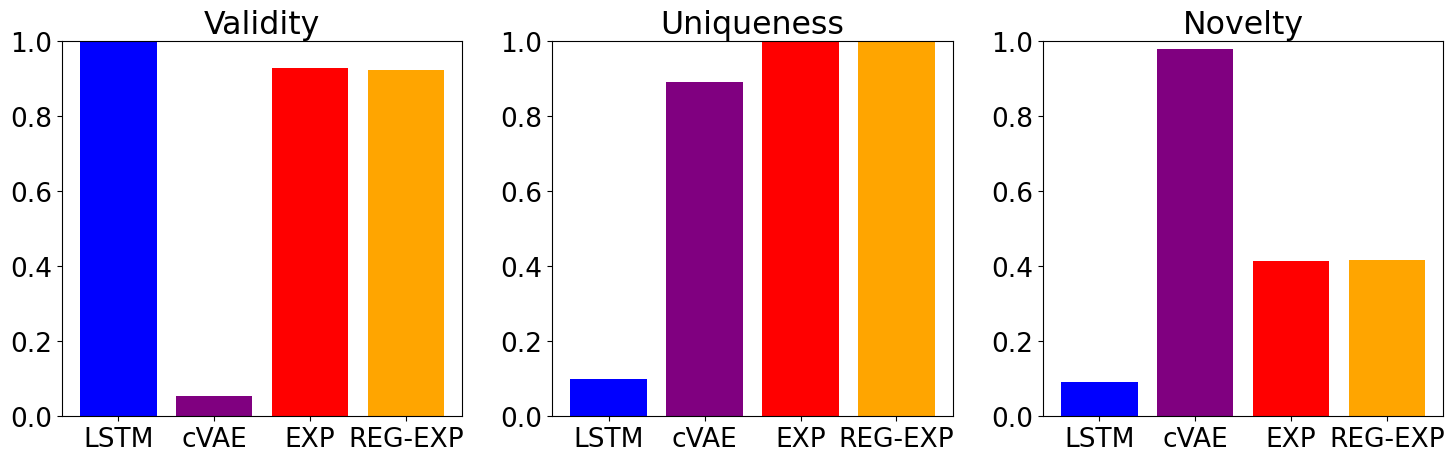

In [ ]:
models = ["LSTM", "cVAE", "EXP", "REG-EXP"]
metrics = ["Validity", "Uniqueness", "Novelty"]
data = {
    "Validity": [
        lstm_metrics[0],
        cvae_metrics[0],
        exp_cvae_metrics[0],
        reg_exp_cvae_metrics[0],
    ],
    "Uniqueness": [
        lstm_metrics[1],
        cvae_metrics[1],
        exp_cvae_metrics[1],
        reg_exp_cvae_metrics[1],
    ],
    "Novelty": [
        lstm_metrics[2],
        cvae_metrics[2],
        exp_cvae_metrics[2],
        reg_exp_cvae_metrics[2],
    ],
}

# Plotting
fig, axes = plt.subplots(1, len(metrics), figsize=(15, 5))

for ax, metric in zip(axes, metrics):
    ax.bar(models, data[metric], color=["blue", "purple", "red", "orange"])
    ax.set_title(metric)
    ax.set_ylim(0, 1)  # Adjust based on your metric score range

plt.tight_layout()
plt.show()

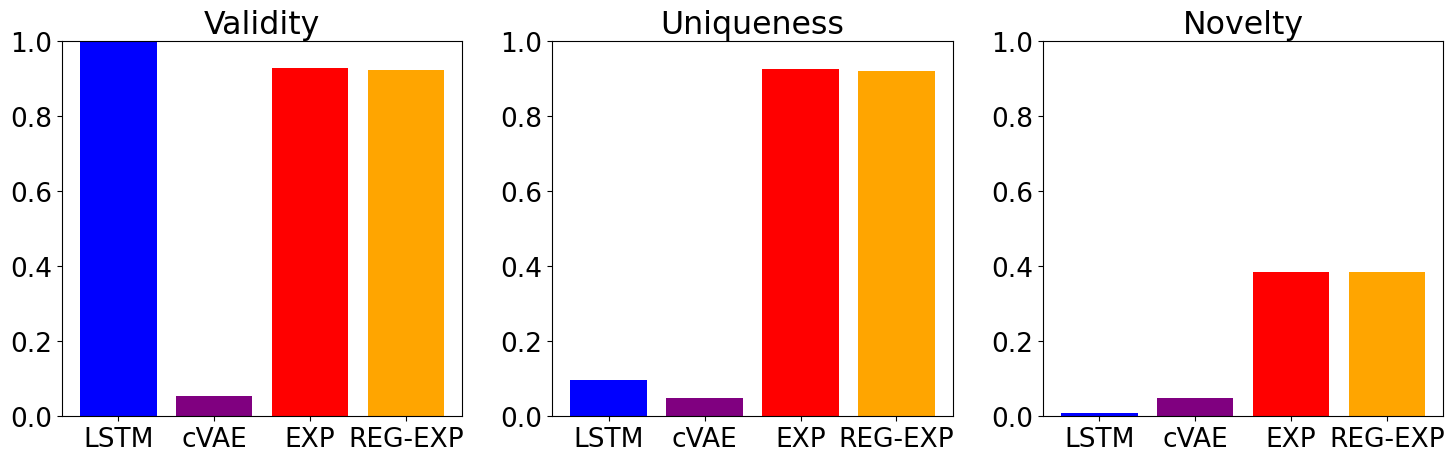

In [ ]:
models = ["LSTM", "cVAE", "EXP", "REG-EXP"]
metrics = ["Validity", "Uniqueness", "Novelty"]
data = {
    "Validity": [
        abs_lstm_metrics[0],
        abs_cvae_metrics[0],
        abs_exp_cvae_metrics[0],
        abs_reg_exp_cvae_metrics[0],
    ],
    "Uniqueness": [
        abs_lstm_metrics[1],
        abs_cvae_metrics[1],
        abs_exp_cvae_metrics[1],
        abs_reg_exp_cvae_metrics[1],
    ],
    "Novelty": [
        abs_lstm_metrics[2],
        abs_cvae_metrics[2],
        abs_exp_cvae_metrics[2],
        abs_reg_exp_cvae_metrics[2],
    ],
}

# Plotting
fig, axes = plt.subplots(1, len(metrics), figsize=(15, 5))

for ax, metric in zip(axes, metrics):
    ax.bar(models, data[metric], color=["blue", "purple", "red", "orange"])
    ax.set_title(metric)
    ax.set_ylim(0, 1)  # Adjust based on your metric score range

plt.tight_layout()
plt.show()

Plot property conditioning metrics (MAE and correlation between property values for comparison with previous paper)

In [112]:
lstm_p_metrics = property_metrics(
    lstm_global_sample_smiles.copy(), target_props, prop_names=["LogP"]
)
cvae_p_metrics = property_metrics(
    cvae_global_sample_smiles.copy(), target_props, prop_names=["LogP"]
)
exp_cvae_p_metrics = property_metrics(
    exp_cvae_global_sample_smiles.copy(), target_props, prop_names=["LogP"]
)
reg_exp_cvae_p_metrics = property_metrics(
    reg_exp_cvae_global_sample_smiles.copy(), target_props, prop_names=["LogP"]
)

/tmp/ipykernel_114660/3673222635.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=list(values.keys()), y=list(values.values()), palette='viridis')
/tmp/ipykernel_114660/3673222635.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=list(values.keys()), y=list(values.values()), palette='viridis')


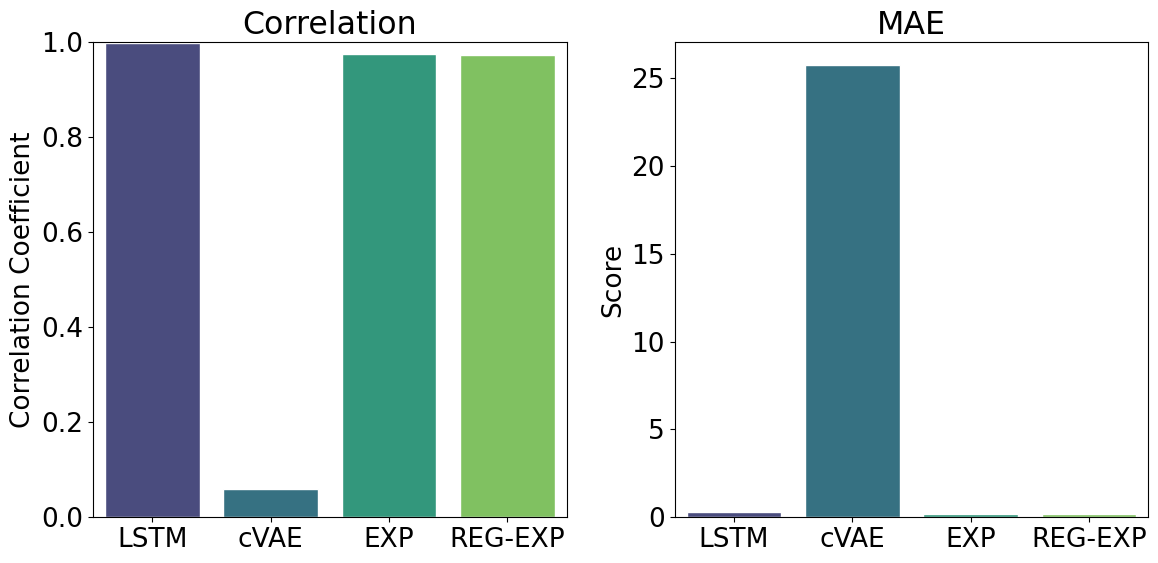

In [ ]:
models = ["LSTM", "SD-LSTM", "VAE", "SD-VAE"]
metrics_data = {
    "Correlation": {
        "LSTM": lstm_p_metrics[0][0],
        "cVAE": cvae_p_metrics[0][0],
        "EXP": exp_cvae_p_metrics[0][0],
        "REG-EXP": reg_exp_cvae_p_metrics[0][0],
    },
    "MAE": {
        "LSTM": float(lstm_p_metrics[1][0]),
        "cVAE": float(cvae_p_metrics[1][0]),
        "EXP": float(exp_cvae_p_metrics[1][0]),
        "REG-EXP": float(reg_exp_cvae_p_metrics[1][0]),
    },
}

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.set_style("whitegrid")

for ax, (metric, values) in zip(axes, metrics_data.items()):
    sns.barplot(
        ax=ax, x=list(values.keys()), y=list(values.values()), palette="viridis"
    )
    ax.set_title(metric)
    ax.set_ylabel("Score" if metric == "MAE" else "Correlation Coefficient")
    ax.set_ylim(
        0, 1 if metric == "Correlation" else None
    )  # Adjust the y-axis limit for correlation

plt.tight_layout()
plt.show()

Plot side by side generated property distributions for a range of target properties. 

In [114]:
property_steps = np.arange(-3, 3, 0.5)
samp_per_step = 500

model_steps_properties = {
    "LSTM": [],
    "cVAE": [],
    "EXP-cVAE": [],
    "REG-EXP-cVAE": [],
}


for p_val in tqdm(property_steps):
    props = torch.Tensor([[p_val] for i in range(samp_per_step)])
    smiles = lstm_sampler.sample(
        model=lstm_model,
        properties=torch.Tensor(props).clone(),
        num_to_sample=samp_per_step,
    )
    model_steps_properties["LSTM"].append(props_from_smiles(smiles))

    smiles = cvae_sampler.sample(
        model=cvae_model,
        properties=torch.Tensor(props).clone(),
    )
    model_steps_properties["cVAE"].append(props_from_smiles(smiles))

    smiles = exp_cvae_sampler.sample(
        model=exp_cvae_model,
        properties=torch.Tensor(props).clone(),
    )
    model_steps_properties["EXP-cVAE"].append(props_from_smiles(smiles))

    smiles = reg_exp_cvae_sampler.sample(
        model=reg_exp_cvae_model,
        properties=torch.Tensor(props).clone(),
    )
    model_steps_properties["REG-EXP-cVAE"].append(props_from_smiles(smiles))


100%|██████████| 500/500 [00:00<00:00, 17637.95it/s]
/home/chrome/Code/De-Novo-Drug/De-novo-drug-design/evaluation/../vae/benchmark_vanilla_vae.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  properties = torch.tensor(properties).clone()
/home/chrome/Code/De-Novo-Drug/De-novo-drug-design/evaluation/../vae/model_vanilla_vae_short.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()

100%|██████████| 500/500 [00:00<00:00, 7782.04it/s]
/home/chrome/Code/De-Novo-Drug/De-novo-drug-design/evaluation/../explicit_vae/action_sampling_vae_sampler.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

/tmp/ipykernel_114660/1670376806.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(model_steps_properties[model][i], ax=ax, label=model, color=color, fill=True)
/tmp/ipykernel_114660/1670376806.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(model_steps_properties[model][i], ax=ax, label=model, color=color, fill=True)
/tmp/ipykernel_114660/1670376806.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(model_steps_properties[model][i], ax=ax, label=model, color=color, fill=True)
/tmp/ipykernel_114660/1670376806.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(model_steps_properties[model][i], ax=ax, label=model, color=color, fill=True)
/tmp/ipy

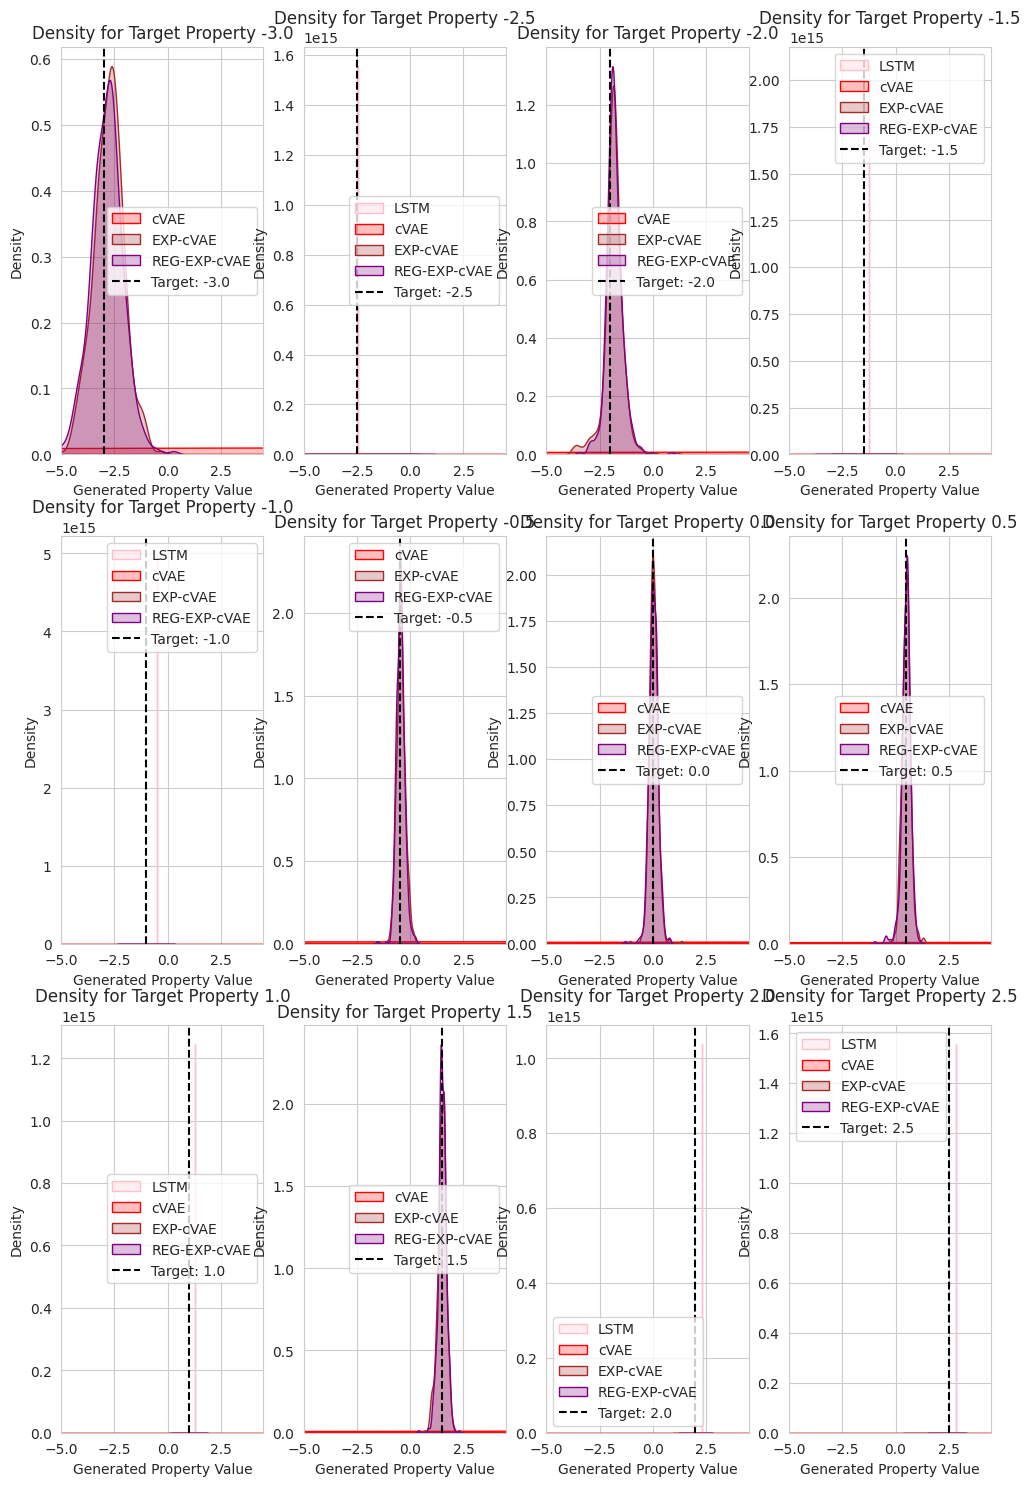

In [116]:
# Example properties range and sampling setup
property_steps = np.arange(-3, 3, 0.5)

plt.rcParams["font.size"] = 10
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 18))  # 6 plots in a 3x2 grid
axs = axs.flatten()

colors = {"LSTM": "pink", "cVAE": "red", "EXP-cVAE": "brown", "REG-EXP-cVAE": "purple"}

for i, (p_val, ax) in enumerate(zip(property_steps, axs)):
    # Plot density for each model
    for model, color in colors.items():
        sns.kdeplot(
            model_steps_properties[model][i], ax=ax, label=model, color=color, fill=True
        )

    # Add a vertical line for the target property
    ax.axvline(
        x=p_val,
        color="black",
        linestyle="--",
        linewidth=1.5,
        label="Target: {:.1f}".format(p_val),
    )

    # Set titles and labels
    ax.set_title(f"Density for Target Property {p_val:.1f}")
    ax.set_xlabel("Generated Property Value")
    ax.set_ylabel("Density")
    ax.set_xlim(property_steps[0] - 2, property_steps[-1] + 2)
    ax.legend()

# plt.tight_layout()
plt.show()